## UNET CNN

In [1]:
from ReadData import *
import matplotlib.pyplot as plt
import numpy as np
# import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, BatchNormalization, Activation, Input, Concatenate, Flatten, Reshape, Dense
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
def readData(path, getTargetName = False):
    # print(getTargetName)
    data = getEMData(path)
    target = []
    field = []
    freq = []
    if getTargetName:
        targetName = []
        upper_case = [char for char in path if char.isupper()]
        target_name = path[path.index(upper_case[0]):path.index(upper_case[1])]

    for i in range(0, len(data)):
        target.append(data[i].target)
        field.append(data[i].Esct.real)
        freq.append(data[i].freq)
        if getTargetName: targetName.append(target_name)

    field = np.array(field)
    target = np.array(target)
    freq = np.array(freq)
    if getTargetName: targetName = np.array(targetName)

    result = (field, target, freq)
    if getTargetName: result = (field, target, freq, targetName)
    return result

In [3]:
fieldMNIST, targetMNIST, freqMNIST = readData(path = "./testing/", getTargetName=False)

fieldMNIST_transformed = np.reshape(fieldMNIST, (fieldMNIST.shape[0], fieldMNIST.shape[1], fieldMNIST.shape[2], 1))
targetMNIST_transformed = np.reshape(targetMNIST, (targetMNIST.shape[0], targetMNIST.shape[1], targetMNIST.shape[2], 1))

fieldMNIST_train, fieldMNIST_test, targetMNIST_train, targetMNIST_test= train_test_split(
    fieldMNIST_transformed, targetMNIST_transformed, test_size=0.20, random_state=42)

fieldMNIST_train, fieldMNIST_val, targetMNIST_train, targetMNIST_val= train_test_split(
    fieldMNIST_train, targetMNIST_train, test_size=0.20, random_state=42)

Read 630 samples


In [4]:
[fieldMNIST_train.shape,targetMNIST_train.shape, fieldMNIST_val.shape, targetMNIST_val.shape]

[(403, 24, 24, 1), (403, 28, 28, 1), (101, 24, 24, 1), (101, 28, 28, 1)]

In [5]:
fieldMNIST_train_padded = np.pad(fieldMNIST_train, ((0, 0), (2, 2), (2, 2), (0, 0)), 'constant')
fieldMNIST_val_padded = np.pad(fieldMNIST_val, ((0, 0), (2, 2), (2, 2), (0, 0)), 'constant')
fieldMNIST_test_padded = np.pad(fieldMNIST_test, ((0, 0), (2, 2), (2, 2), (0, 0)), 'constant')

In [6]:
[fieldMNIST_train_padded.shape,targetMNIST_train.shape, fieldMNIST_val_padded.shape, targetMNIST_val.shape]

[(403, 28, 28, 1), (403, 28, 28, 1), (101, 28, 28, 1), (101, 28, 28, 1)]

In [14]:
def unet_padded(input_shape):
    inputs = Input(input_shape)

    conv1 = Conv2D(64, 3, padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)
    conv1 = Conv2D(64, 3, padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)
    conv1 = Conv2D(64, 3, padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Activation('relu')(conv2)
    conv2 = Conv2D(128, 3, padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    conv2 = Activation('relu')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    # Bottleneck
    bottleneck = Conv2D(256, 3, padding='same')(pool2)
    bottleneck = BatchNormalization()(bottleneck)
    bottleneck = Activation('relu')(bottleneck)
    bottleneck = Conv2D(256, 3, padding='same')(bottleneck)
    bottleneck = BatchNormalization()(bottleneck)
    bottleneck = Activation('relu')(bottleneck)

    # Expansive Path
    up1 = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same')(bottleneck)
    skip1 = Concatenate(axis=-1)([conv2, up1])
    conv3 = Conv2D(128, 3, padding='same')(skip1)
    conv3 = BatchNormalization()(conv3)
    conv3 = Activation('relu')(conv3)
    conv3 = Conv2D(128, 3, padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv3 = Activation('relu')(conv3)

    up2 = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same')(conv3)
    skip2 = Concatenate(axis=-1)([conv1, up2])
    conv4 = Conv2D(64, 3, padding='same')(skip2)
    conv4 = BatchNormalization()(conv4)
    conv4 = Activation('relu')(conv4)
    conv4 = Conv2D(64, 3, padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    conv4 = Activation('relu')(conv4)

    # up3 = Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same')(conv4)
    # # skip2 = Concatenate(axis=-1)([conv1, up2])
    # conv5 = Conv2D(32, 3, padding='same')(up3)
    # conv5 = BatchNormalization()(conv5)
    # conv5 = Activation('relu')(conv5)
    # conv5 = Conv2D(32, 3, padding='same')(conv5)
    # conv5 = BatchNormalization()(conv5)
    # conv5 = Activation('relu')(conv5)

    output = Conv2D(1, 1, activation='sigmoid')(conv4)

    # output = Conv2D(n_class, 1, activation='softmax')(conv4)

    # Cropping to the desired size (35, 35)
    # cropped_output = Cropping2D(((7, 6), (7, 6)))(output)
    # skip3 = Concatenate(axis=-1)([input, cropped_output])


    model = Model(inputs=inputs, outputs=output)

    return model

In [15]:
inputMNIST_shape_padded = fieldMNIST_train_padded.shape[1:]
model_mnist_padded = unet_padded(inputMNIST_shape_padded)
model_mnist_padded.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_12 (Conv2D)             (None, 28, 28, 64)   640         ['input_2[0][0]']                
                                                                                                  
 batch_normalization_11 (BatchN  (None, 28, 28, 64)  256         ['conv2d_12[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_11 (Activation)     (None, 28, 28, 64)   0           ['batch_normalization_11[0]

Train on MNIST then test on shape (freq 1e9 and permitivity 2)

In [17]:
init_lr = 1e-4
# final_lr = 1e-8
total_epoch = 200

In [18]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("./model_weights/", monitor="val_loss", mode="min", save_best_only=True, 
                                                verbose=0, overwrite=True)
earlyStop = EarlyStopping(monitor='loss',patience=3)

model_mnist_padded.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=init_lr), loss = 'mean_squared_error', 
                    metrics = 'accuracy')
hist_padded = model_mnist_padded.fit(x = fieldMNIST_train_padded, y = targetMNIST_train, 
                                    validation_data=(fieldMNIST_val_padded, targetMNIST_val), 
                                    batch_size = 20, epochs = total_epoch, 
                                    callbacks = [earlyStop, checkpoint])

Epoch 1/200
21/21 [==============================] - ETA: 0s - loss: 0.3107 - accuracy: 0.4271

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


21/21 [==============================] - 21s 962ms/step - loss: 0.3107 - accuracy: 0.4271 - val_loss: 0.2519 - val_accuracy: 0.3769
Epoch 2/200
21/21 [==============================] - 11s 550ms/step - loss: 0.3056 - accuracy: 0.4415 - val_loss: 0.2531 - val_accuracy: 0.4180
Epoch 3/200
21/21 [==============================] - 11s 527ms/step - loss: 0.3006 - accuracy: 0.4561 - val_loss: 0.2534 - val_accuracy: 0.4450
Epoch 4/200
21/21 [==============================] - 11s 533ms/step - loss: 0.2965 - accuracy: 0.4707 - val_loss: 0.2530 - val_accuracy: 0.4634
Epoch 5/200
21/21 [==============================] - ETA: 0s - loss: 0.2921 - accuracy: 0.4858

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


21/21 [==============================] - 15s 749ms/step - loss: 0.2921 - accuracy: 0.4858 - val_loss: 0.2519 - val_accuracy: 0.4850
Epoch 6/200
21/21 [==============================] - ETA: 0s - loss: 0.2883 - accuracy: 0.5007

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


21/21 [==============================] - 15s 746ms/step - loss: 0.2883 - accuracy: 0.5007 - val_loss: 0.2502 - val_accuracy: 0.5157
Epoch 7/200
21/21 [==============================] - ETA: 0s - loss: 0.2845 - accuracy: 0.5156

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


21/21 [==============================] - 17s 800ms/step - loss: 0.2845 - accuracy: 0.5156 - val_loss: 0.2482 - val_accuracy: 0.5377
Epoch 8/200
21/21 [==============================] - ETA: 0s - loss: 0.2808 - accuracy: 0.5289

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


21/21 [==============================] - 19s 923ms/step - loss: 0.2808 - accuracy: 0.5289 - val_loss: 0.2459 - val_accuracy: 0.5587
Epoch 9/200
21/21 [==============================] - ETA: 0s - loss: 0.2773 - accuracy: 0.5424

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


21/21 [==============================] - 17s 810ms/step - loss: 0.2773 - accuracy: 0.5424 - val_loss: 0.2435 - val_accuracy: 0.5772
Epoch 10/200
21/21 [==============================] - ETA: 0s - loss: 0.2743 - accuracy: 0.5537

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


21/21 [==============================] - 17s 816ms/step - loss: 0.2743 - accuracy: 0.5537 - val_loss: 0.2409 - val_accuracy: 0.5940
Epoch 11/200
21/21 [==============================] - ETA: 0s - loss: 0.2715 - accuracy: 0.5643

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


21/21 [==============================] - 19s 916ms/step - loss: 0.2715 - accuracy: 0.5643 - val_loss: 0.2384 - val_accuracy: 0.6103
Epoch 12/200
21/21 [==============================] - ETA: 0s - loss: 0.2685 - accuracy: 0.5748

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


21/21 [==============================] - 21s 1s/step - loss: 0.2685 - accuracy: 0.5748 - val_loss: 0.2362 - val_accuracy: 0.6311
Epoch 13/200
21/21 [==============================] - ETA: 0s - loss: 0.2656 - accuracy: 0.5846

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


21/21 [==============================] - 16s 778ms/step - loss: 0.2656 - accuracy: 0.5846 - val_loss: 0.2344 - val_accuracy: 0.6402
Epoch 14/200
21/21 [==============================] - ETA: 0s - loss: 0.2634 - accuracy: 0.5927

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


21/21 [==============================] - 18s 870ms/step - loss: 0.2634 - accuracy: 0.5927 - val_loss: 0.2328 - val_accuracy: 0.6454
Epoch 15/200
21/21 [==============================] - ETA: 0s - loss: 0.2604 - accuracy: 0.6015

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


21/21 [==============================] - 18s 850ms/step - loss: 0.2604 - accuracy: 0.6015 - val_loss: 0.2316 - val_accuracy: 0.6497
Epoch 16/200
21/21 [==============================] - ETA: 0s - loss: 0.2581 - accuracy: 0.6102

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


21/21 [==============================] - 17s 815ms/step - loss: 0.2581 - accuracy: 0.6102 - val_loss: 0.2305 - val_accuracy: 0.6530
Epoch 17/200
21/21 [==============================] - ETA: 0s - loss: 0.2554 - accuracy: 0.6171

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


21/21 [==============================] - 16s 803ms/step - loss: 0.2554 - accuracy: 0.6171 - val_loss: 0.2295 - val_accuracy: 0.6558
Epoch 18/200
21/21 [==============================] - ETA: 0s - loss: 0.2536 - accuracy: 0.6235

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


21/21 [==============================] - 16s 788ms/step - loss: 0.2536 - accuracy: 0.6235 - val_loss: 0.2286 - val_accuracy: 0.6583
Epoch 19/200
21/21 [==============================] - ETA: 0s - loss: 0.2507 - accuracy: 0.6305

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


21/21 [==============================] - 17s 840ms/step - loss: 0.2507 - accuracy: 0.6305 - val_loss: 0.2276 - val_accuracy: 0.6614
Epoch 20/200
21/21 [==============================] - ETA: 0s - loss: 0.2483 - accuracy: 0.6365

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


21/21 [==============================] - 16s 779ms/step - loss: 0.2483 - accuracy: 0.6365 - val_loss: 0.2265 - val_accuracy: 0.6645
Epoch 21/200
21/21 [==============================] - ETA: 0s - loss: 0.2466 - accuracy: 0.6415

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


21/21 [==============================] - 15s 750ms/step - loss: 0.2466 - accuracy: 0.6415 - val_loss: 0.2253 - val_accuracy: 0.6681
Epoch 22/200
21/21 [==============================] - ETA: 0s - loss: 0.2444 - accuracy: 0.6472

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


21/21 [==============================] - 15s 745ms/step - loss: 0.2444 - accuracy: 0.6472 - val_loss: 0.2237 - val_accuracy: 0.6710
Epoch 23/200
21/21 [==============================] - ETA: 0s - loss: 0.2421 - accuracy: 0.6526

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


21/21 [==============================] - 16s 757ms/step - loss: 0.2421 - accuracy: 0.6526 - val_loss: 0.2219 - val_accuracy: 0.6740
Epoch 24/200
21/21 [==============================] - ETA: 0s - loss: 0.2409 - accuracy: 0.6570

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


21/21 [==============================] - 18s 877ms/step - loss: 0.2409 - accuracy: 0.6570 - val_loss: 0.2195 - val_accuracy: 0.6764
Epoch 25/200
21/21 [==============================] - ETA: 0s - loss: 0.2378 - accuracy: 0.6627

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


21/21 [==============================] - 20s 967ms/step - loss: 0.2378 - accuracy: 0.6627 - val_loss: 0.2165 - val_accuracy: 0.6790
Epoch 26/200
21/21 [==============================] - ETA: 0s - loss: 0.2364 - accuracy: 0.6670

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


21/21 [==============================] - 18s 872ms/step - loss: 0.2364 - accuracy: 0.6670 - val_loss: 0.2133 - val_accuracy: 0.6824
Epoch 27/200
21/21 [==============================] - ETA: 0s - loss: 0.2341 - accuracy: 0.6719

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


21/21 [==============================] - 17s 823ms/step - loss: 0.2341 - accuracy: 0.6719 - val_loss: 0.2099 - val_accuracy: 0.6858
Epoch 28/200
21/21 [==============================] - ETA: 0s - loss: 0.2326 - accuracy: 0.6754

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


21/21 [==============================] - 15s 727ms/step - loss: 0.2326 - accuracy: 0.6754 - val_loss: 0.2063 - val_accuracy: 0.6898
Epoch 29/200
21/21 [==============================] - ETA: 0s - loss: 0.2309 - accuracy: 0.6787

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


21/21 [==============================] - 17s 832ms/step - loss: 0.2309 - accuracy: 0.6787 - val_loss: 0.2027 - val_accuracy: 0.6955
Epoch 30/200
21/21 [==============================] - ETA: 0s - loss: 0.2284 - accuracy: 0.6841

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


21/21 [==============================] - 16s 758ms/step - loss: 0.2284 - accuracy: 0.6841 - val_loss: 0.1997 - val_accuracy: 0.7012
Epoch 31/200
21/21 [==============================] - ETA: 0s - loss: 0.2266 - accuracy: 0.6880

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


21/21 [==============================] - 16s 756ms/step - loss: 0.2266 - accuracy: 0.6880 - val_loss: 0.1974 - val_accuracy: 0.7075
Epoch 32/200
21/21 [==============================] - ETA: 0s - loss: 0.2245 - accuracy: 0.6923

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


21/21 [==============================] - 15s 739ms/step - loss: 0.2245 - accuracy: 0.6923 - val_loss: 0.1959 - val_accuracy: 0.7129
Epoch 33/200
21/21 [==============================] - ETA: 0s - loss: 0.2229 - accuracy: 0.6958

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


21/21 [==============================] - 15s 724ms/step - loss: 0.2229 - accuracy: 0.6958 - val_loss: 0.1955 - val_accuracy: 0.7182
Epoch 34/200
21/21 [==============================] - 11s 539ms/step - loss: 0.2209 - accuracy: 0.6998 - val_loss: 0.1958 - val_accuracy: 0.7217
Epoch 35/200
21/21 [==============================] - 12s 589ms/step - loss: 0.2198 - accuracy: 0.7023 - val_loss: 0.1971 - val_accuracy: 0.7231
Epoch 36/200
21/21 [==============================] - 12s 560ms/step - loss: 0.2171 - accuracy: 0.7072 - val_loss: 0.1989 - val_accuracy: 0.7225
Epoch 37/200
21/21 [==============================] - 11s 549ms/step - loss: 0.2159 - accuracy: 0.7099 - val_loss: 0.2008 - val_accuracy: 0.7210
Epoch 38/200
21/21 [==============================] - 11s 546ms/step - loss: 0.2139 - accuracy: 0.7135 - val_loss: 0.2030 - val_accuracy: 0.7201
Epoch 39/200
21/21 [==============================] - 11s 538ms/step - loss: 0.2122 - accuracy: 0.7166 - val_loss: 0.2050 - val_accuracy: 0.719

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


21/21 [==============================] - 16s 789ms/step - loss: 0.1830 - accuracy: 0.7645 - val_loss: 0.1950 - val_accuracy: 0.7479
Epoch 62/200
21/21 [==============================] - ETA: 0s - loss: 0.1811 - accuracy: 0.7671

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


21/21 [==============================] - 17s 810ms/step - loss: 0.1811 - accuracy: 0.7671 - val_loss: 0.1937 - val_accuracy: 0.7494
Epoch 63/200
21/21 [==============================] - ETA: 0s - loss: 0.1802 - accuracy: 0.7688

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


21/21 [==============================] - 16s 784ms/step - loss: 0.1802 - accuracy: 0.7688 - val_loss: 0.1917 - val_accuracy: 0.7517
Epoch 64/200
21/21 [==============================] - ETA: 0s - loss: 0.1802 - accuracy: 0.7697

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


21/21 [==============================] - 16s 765ms/step - loss: 0.1802 - accuracy: 0.7697 - val_loss: 0.1899 - val_accuracy: 0.7539
Epoch 65/200
21/21 [==============================] - ETA: 0s - loss: 0.1786 - accuracy: 0.7706

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


21/21 [==============================] - 17s 825ms/step - loss: 0.1786 - accuracy: 0.7706 - val_loss: 0.1888 - val_accuracy: 0.7556
Epoch 66/200
21/21 [==============================] - ETA: 0s - loss: 0.1771 - accuracy: 0.7736

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


21/21 [==============================] - 16s 747ms/step - loss: 0.1771 - accuracy: 0.7736 - val_loss: 0.1876 - val_accuracy: 0.7569
Epoch 67/200
21/21 [==============================] - ETA: 0s - loss: 0.1762 - accuracy: 0.7748

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


21/21 [==============================] - 14s 683ms/step - loss: 0.1762 - accuracy: 0.7748 - val_loss: 0.1866 - val_accuracy: 0.7581
Epoch 68/200
21/21 [==============================] - ETA: 0s - loss: 0.1753 - accuracy: 0.7763

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


21/21 [==============================] - 14s 695ms/step - loss: 0.1753 - accuracy: 0.7763 - val_loss: 0.1853 - val_accuracy: 0.7599
Epoch 69/200
21/21 [==============================] - ETA: 0s - loss: 0.1741 - accuracy: 0.7774

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


21/21 [==============================] - 14s 696ms/step - loss: 0.1741 - accuracy: 0.7774 - val_loss: 0.1840 - val_accuracy: 0.7615
Epoch 70/200
21/21 [==============================] - ETA: 0s - loss: 0.1730 - accuracy: 0.7796

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


21/21 [==============================] - 17s 831ms/step - loss: 0.1730 - accuracy: 0.7796 - val_loss: 0.1826 - val_accuracy: 0.7634
Epoch 71/200
21/21 [==============================] - ETA: 0s - loss: 0.1711 - accuracy: 0.7811

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


21/21 [==============================] - 15s 726ms/step - loss: 0.1711 - accuracy: 0.7811 - val_loss: 0.1811 - val_accuracy: 0.7654
Epoch 72/200
21/21 [==============================] - ETA: 0s - loss: 0.1708 - accuracy: 0.7826

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


21/21 [==============================] - 14s 673ms/step - loss: 0.1708 - accuracy: 0.7826 - val_loss: 0.1797 - val_accuracy: 0.7667
Epoch 73/200
21/21 [==============================] - ETA: 0s - loss: 0.1706 - accuracy: 0.7827

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


21/21 [==============================] - 14s 672ms/step - loss: 0.1706 - accuracy: 0.7827 - val_loss: 0.1785 - val_accuracy: 0.7686
Epoch 74/200
21/21 [==============================] - ETA: 0s - loss: 0.1685 - accuracy: 0.7854

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


21/21 [==============================] - 15s 729ms/step - loss: 0.1685 - accuracy: 0.7854 - val_loss: 0.1773 - val_accuracy: 0.7702
Epoch 75/200
21/21 [==============================] - ETA: 0s - loss: 0.1676 - accuracy: 0.7864

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


21/21 [==============================] - 20s 961ms/step - loss: 0.1676 - accuracy: 0.7864 - val_loss: 0.1764 - val_accuracy: 0.7713
Epoch 76/200
21/21 [==============================] - ETA: 0s - loss: 0.1679 - accuracy: 0.7868

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


21/21 [==============================] - 18s 881ms/step - loss: 0.1679 - accuracy: 0.7868 - val_loss: 0.1755 - val_accuracy: 0.7723
Epoch 77/200
21/21 [==============================] - ETA: 0s - loss: 0.1663 - accuracy: 0.7886

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


21/21 [==============================] - 21s 1s/step - loss: 0.1663 - accuracy: 0.7886 - val_loss: 0.1746 - val_accuracy: 0.7736
Epoch 78/200
21/21 [==============================] - ETA: 0s - loss: 0.1644 - accuracy: 0.7918

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


21/21 [==============================] - 21s 1s/step - loss: 0.1644 - accuracy: 0.7918 - val_loss: 0.1733 - val_accuracy: 0.7750
Epoch 79/200
21/21 [==============================] - ETA: 0s - loss: 0.1642 - accuracy: 0.7923

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


21/21 [==============================] - 21s 1s/step - loss: 0.1642 - accuracy: 0.7923 - val_loss: 0.1720 - val_accuracy: 0.7765
Epoch 80/200
21/21 [==============================] - ETA: 0s - loss: 0.1634 - accuracy: 0.7925

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


21/21 [==============================] - 21s 1s/step - loss: 0.1634 - accuracy: 0.7925 - val_loss: 0.1708 - val_accuracy: 0.7781
Epoch 81/200
21/21 [==============================] - ETA: 0s - loss: 0.1625 - accuracy: 0.7938

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


21/21 [==============================] - 20s 973ms/step - loss: 0.1625 - accuracy: 0.7938 - val_loss: 0.1695 - val_accuracy: 0.7793
Epoch 82/200
21/21 [==============================] - ETA: 0s - loss: 0.1626 - accuracy: 0.7937

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


21/21 [==============================] - 18s 901ms/step - loss: 0.1626 - accuracy: 0.7937 - val_loss: 0.1688 - val_accuracy: 0.7803
Epoch 83/200
21/21 [==============================] - ETA: 0s - loss: 0.1612 - accuracy: 0.7956

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


21/21 [==============================] - 22s 1s/step - loss: 0.1612 - accuracy: 0.7956 - val_loss: 0.1675 - val_accuracy: 0.7819
Epoch 84/200
21/21 [==============================] - ETA: 0s - loss: 0.1601 - accuracy: 0.7977

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


21/21 [==============================] - 25s 1s/step - loss: 0.1601 - accuracy: 0.7977 - val_loss: 0.1666 - val_accuracy: 0.7835
Epoch 85/200
21/21 [==============================] - ETA: 0s - loss: 0.1604 - accuracy: 0.7971

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


21/21 [==============================] - 24s 1s/step - loss: 0.1604 - accuracy: 0.7971 - val_loss: 0.1653 - val_accuracy: 0.7850
Epoch 86/200
21/21 [==============================] - ETA: 0s - loss: 0.1592 - accuracy: 0.7984

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


21/21 [==============================] - 19s 908ms/step - loss: 0.1592 - accuracy: 0.7984 - val_loss: 0.1646 - val_accuracy: 0.7859
Epoch 87/200
21/21 [==============================] - ETA: 0s - loss: 0.1583 - accuracy: 0.7993

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


21/21 [==============================] - 19s 924ms/step - loss: 0.1583 - accuracy: 0.7993 - val_loss: 0.1638 - val_accuracy: 0.7867
Epoch 88/200
21/21 [==============================] - ETA: 0s - loss: 0.1574 - accuracy: 0.8013

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


21/21 [==============================] - 23s 1s/step - loss: 0.1574 - accuracy: 0.8013 - val_loss: 0.1632 - val_accuracy: 0.7875
Epoch 89/200
21/21 [==============================] - ETA: 0s - loss: 0.1564 - accuracy: 0.8020

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


21/21 [==============================] - 25s 1s/step - loss: 0.1564 - accuracy: 0.8020 - val_loss: 0.1621 - val_accuracy: 0.7888
Epoch 90/200
21/21 [==============================] - ETA: 0s - loss: 0.1558 - accuracy: 0.8030

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


21/21 [==============================] - 21s 1s/step - loss: 0.1558 - accuracy: 0.8030 - val_loss: 0.1612 - val_accuracy: 0.7900
Epoch 91/200
21/21 [==============================] - ETA: 0s - loss: 0.1548 - accuracy: 0.8038

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


21/21 [==============================] - 19s 930ms/step - loss: 0.1548 - accuracy: 0.8038 - val_loss: 0.1606 - val_accuracy: 0.7908
Epoch 92/200
21/21 [==============================] - ETA: 0s - loss: 0.1546 - accuracy: 0.8041

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


21/21 [==============================] - 19s 925ms/step - loss: 0.1546 - accuracy: 0.8041 - val_loss: 0.1595 - val_accuracy: 0.7920
Epoch 93/200
21/21 [==============================] - ETA: 0s - loss: 0.1539 - accuracy: 0.8050

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


21/21 [==============================] - 17s 827ms/step - loss: 0.1539 - accuracy: 0.8050 - val_loss: 0.1585 - val_accuracy: 0.7932
Epoch 94/200
21/21 [==============================] - ETA: 0s - loss: 0.1526 - accuracy: 0.8070

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


21/21 [==============================] - 16s 779ms/step - loss: 0.1526 - accuracy: 0.8070 - val_loss: 0.1579 - val_accuracy: 0.7938
Epoch 95/200
21/21 [==============================] - ETA: 0s - loss: 0.1533 - accuracy: 0.8062

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


21/21 [==============================] - 15s 720ms/step - loss: 0.1533 - accuracy: 0.8062 - val_loss: 0.1579 - val_accuracy: 0.7942
Epoch 96/200
21/21 [==============================] - ETA: 0s - loss: 0.1528 - accuracy: 0.8065

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


21/21 [==============================] - 16s 791ms/step - loss: 0.1528 - accuracy: 0.8065 - val_loss: 0.1571 - val_accuracy: 0.7952
Epoch 97/200
21/21 [==============================] - ETA: 0s - loss: 0.1515 - accuracy: 0.8085

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


21/21 [==============================] - 19s 900ms/step - loss: 0.1515 - accuracy: 0.8085 - val_loss: 0.1556 - val_accuracy: 0.7966
Epoch 98/200
21/21 [==============================] - ETA: 0s - loss: 0.1507 - accuracy: 0.8095

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


21/21 [==============================] - 16s 734ms/step - loss: 0.1507 - accuracy: 0.8095 - val_loss: 0.1548 - val_accuracy: 0.7973
Epoch 99/200
21/21 [==============================] - ETA: 0s - loss: 0.1502 - accuracy: 0.8098

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


21/21 [==============================] - 16s 793ms/step - loss: 0.1502 - accuracy: 0.8098 - val_loss: 0.1545 - val_accuracy: 0.7977
Epoch 100/200
21/21 [==============================] - ETA: 0s - loss: 0.1490 - accuracy: 0.8119

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


21/21 [==============================] - 16s 762ms/step - loss: 0.1490 - accuracy: 0.8119 - val_loss: 0.1536 - val_accuracy: 0.7991
Epoch 101/200
21/21 [==============================] - ETA: 0s - loss: 0.1488 - accuracy: 0.8116

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


21/21 [==============================] - 19s 927ms/step - loss: 0.1488 - accuracy: 0.8116 - val_loss: 0.1531 - val_accuracy: 0.8002
Epoch 102/200
21/21 [==============================] - ETA: 0s - loss: 0.1483 - accuracy: 0.8125

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


21/21 [==============================] - 22s 1s/step - loss: 0.1483 - accuracy: 0.8125 - val_loss: 0.1519 - val_accuracy: 0.8014
Epoch 103/200
21/21 [==============================] - ETA: 0s - loss: 0.1472 - accuracy: 0.8140

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


21/21 [==============================] - 18s 852ms/step - loss: 0.1472 - accuracy: 0.8140 - val_loss: 0.1516 - val_accuracy: 0.8017
Epoch 104/200
21/21 [==============================] - ETA: 0s - loss: 0.1470 - accuracy: 0.8146

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


21/21 [==============================] - 17s 807ms/step - loss: 0.1470 - accuracy: 0.8146 - val_loss: 0.1513 - val_accuracy: 0.8024
Epoch 105/200
21/21 [==============================] - ETA: 0s - loss: 0.1457 - accuracy: 0.8158

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


21/21 [==============================] - 19s 921ms/step - loss: 0.1457 - accuracy: 0.8158 - val_loss: 0.1504 - val_accuracy: 0.8031
Epoch 106/200
21/21 [==============================] - ETA: 0s - loss: 0.1460 - accuracy: 0.8159

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


21/21 [==============================] - 17s 817ms/step - loss: 0.1460 - accuracy: 0.8159 - val_loss: 0.1500 - val_accuracy: 0.8036
Epoch 107/200
21/21 [==============================] - ETA: 0s - loss: 0.1451 - accuracy: 0.8166

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


21/21 [==============================] - 18s 881ms/step - loss: 0.1451 - accuracy: 0.8166 - val_loss: 0.1494 - val_accuracy: 0.8044
Epoch 108/200
21/21 [==============================] - ETA: 0s - loss: 0.1437 - accuracy: 0.8186

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


21/21 [==============================] - 16s 769ms/step - loss: 0.1437 - accuracy: 0.8186 - val_loss: 0.1489 - val_accuracy: 0.8050
Epoch 109/200
21/21 [==============================] - ETA: 0s - loss: 0.1443 - accuracy: 0.8171

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


21/21 [==============================] - 18s 859ms/step - loss: 0.1443 - accuracy: 0.8171 - val_loss: 0.1485 - val_accuracy: 0.8056
Epoch 110/200
21/21 [==============================] - ETA: 0s - loss: 0.1426 - accuracy: 0.8197

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


21/21 [==============================] - 17s 843ms/step - loss: 0.1426 - accuracy: 0.8197 - val_loss: 0.1479 - val_accuracy: 0.8062
Epoch 111/200
21/21 [==============================] - ETA: 0s - loss: 0.1429 - accuracy: 0.8189

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


21/21 [==============================] - 16s 760ms/step - loss: 0.1429 - accuracy: 0.8189 - val_loss: 0.1473 - val_accuracy: 0.8070
Epoch 112/200
21/21 [==============================] - ETA: 0s - loss: 0.1426 - accuracy: 0.8195

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


21/21 [==============================] - 16s 768ms/step - loss: 0.1426 - accuracy: 0.8195 - val_loss: 0.1465 - val_accuracy: 0.8079
Epoch 113/200
21/21 [==============================] - ETA: 0s - loss: 0.1422 - accuracy: 0.8208

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


21/21 [==============================] - 16s 787ms/step - loss: 0.1422 - accuracy: 0.8208 - val_loss: 0.1456 - val_accuracy: 0.8088
Epoch 114/200
21/21 [==============================] - ETA: 0s - loss: 0.1407 - accuracy: 0.8227

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


21/21 [==============================] - 16s 760ms/step - loss: 0.1407 - accuracy: 0.8227 - val_loss: 0.1454 - val_accuracy: 0.8093
Epoch 115/200
21/21 [==============================] - ETA: 0s - loss: 0.1405 - accuracy: 0.8231

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


21/21 [==============================] - 16s 776ms/step - loss: 0.1405 - accuracy: 0.8231 - val_loss: 0.1450 - val_accuracy: 0.8100
Epoch 116/200
21/21 [==============================] - ETA: 0s - loss: 0.1403 - accuracy: 0.8230

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


21/21 [==============================] - 16s 766ms/step - loss: 0.1403 - accuracy: 0.8230 - val_loss: 0.1447 - val_accuracy: 0.8106
Epoch 117/200
21/21 [==============================] - ETA: 0s - loss: 0.1391 - accuracy: 0.8241

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


21/21 [==============================] - 18s 851ms/step - loss: 0.1391 - accuracy: 0.8241 - val_loss: 0.1440 - val_accuracy: 0.8115
Epoch 118/200
21/21 [==============================] - ETA: 0s - loss: 0.1390 - accuracy: 0.8249

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


21/21 [==============================] - 16s 765ms/step - loss: 0.1390 - accuracy: 0.8249 - val_loss: 0.1435 - val_accuracy: 0.8125
Epoch 119/200
21/21 [==============================] - ETA: 0s - loss: 0.1384 - accuracy: 0.8252

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


21/21 [==============================] - 16s 771ms/step - loss: 0.1384 - accuracy: 0.8252 - val_loss: 0.1431 - val_accuracy: 0.8131
Epoch 120/200
21/21 [==============================] - ETA: 0s - loss: 0.1371 - accuracy: 0.8271

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


21/21 [==============================] - 26s 1s/step - loss: 0.1371 - accuracy: 0.8271 - val_loss: 0.1426 - val_accuracy: 0.8141
Epoch 121/200
21/21 [==============================] - ETA: 0s - loss: 0.1367 - accuracy: 0.8279

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


21/21 [==============================] - 20s 963ms/step - loss: 0.1367 - accuracy: 0.8279 - val_loss: 0.1425 - val_accuracy: 0.8145
Epoch 122/200
21/21 [==============================] - ETA: 0s - loss: 0.1365 - accuracy: 0.8279

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


21/21 [==============================] - 17s 808ms/step - loss: 0.1365 - accuracy: 0.8279 - val_loss: 0.1417 - val_accuracy: 0.8153
Epoch 123/200
21/21 [==============================] - ETA: 0s - loss: 0.1359 - accuracy: 0.8291

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


21/21 [==============================] - 15s 741ms/step - loss: 0.1359 - accuracy: 0.8291 - val_loss: 0.1409 - val_accuracy: 0.8165
Epoch 124/200
21/21 [==============================] - ETA: 0s - loss: 0.1356 - accuracy: 0.8292

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


21/21 [==============================] - 19s 942ms/step - loss: 0.1356 - accuracy: 0.8292 - val_loss: 0.1405 - val_accuracy: 0.8170
Epoch 125/200
21/21 [==============================] - ETA: 0s - loss: 0.1362 - accuracy: 0.8280

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


21/21 [==============================] - 19s 909ms/step - loss: 0.1362 - accuracy: 0.8280 - val_loss: 0.1399 - val_accuracy: 0.8179
Epoch 126/200
21/21 [==============================] - ETA: 0s - loss: 0.1349 - accuracy: 0.8297

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


21/21 [==============================] - 16s 800ms/step - loss: 0.1349 - accuracy: 0.8297 - val_loss: 0.1398 - val_accuracy: 0.8182
Epoch 127/200
21/21 [==============================] - ETA: 0s - loss: 0.1340 - accuracy: 0.8314

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


21/21 [==============================] - 17s 836ms/step - loss: 0.1340 - accuracy: 0.8314 - val_loss: 0.1389 - val_accuracy: 0.8188
Epoch 128/200
21/21 [==============================] - ETA: 0s - loss: 0.1334 - accuracy: 0.8317

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


21/21 [==============================] - 15s 738ms/step - loss: 0.1334 - accuracy: 0.8317 - val_loss: 0.1384 - val_accuracy: 0.8196
Epoch 129/200
21/21 [==============================] - 11s 547ms/step - loss: 0.1334 - accuracy: 0.8319 - val_loss: 0.1384 - val_accuracy: 0.8197
Epoch 130/200
21/21 [==============================] - ETA: 0s - loss: 0.1328 - accuracy: 0.8329

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


21/21 [==============================] - 15s 748ms/step - loss: 0.1328 - accuracy: 0.8329 - val_loss: 0.1376 - val_accuracy: 0.8205
Epoch 131/200
21/21 [==============================] - ETA: 0s - loss: 0.1320 - accuracy: 0.8338

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


21/21 [==============================] - 15s 743ms/step - loss: 0.1320 - accuracy: 0.8338 - val_loss: 0.1372 - val_accuracy: 0.8207
Epoch 132/200
21/21 [==============================] - ETA: 0s - loss: 0.1315 - accuracy: 0.8342

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


21/21 [==============================] - 16s 785ms/step - loss: 0.1315 - accuracy: 0.8342 - val_loss: 0.1371 - val_accuracy: 0.8208
Epoch 133/200
21/21 [==============================] - ETA: 0s - loss: 0.1305 - accuracy: 0.8360

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


21/21 [==============================] - 17s 826ms/step - loss: 0.1305 - accuracy: 0.8360 - val_loss: 0.1367 - val_accuracy: 0.8212
Epoch 134/200
21/21 [==============================] - ETA: 0s - loss: 0.1308 - accuracy: 0.8352

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


21/21 [==============================] - 16s 767ms/step - loss: 0.1308 - accuracy: 0.8352 - val_loss: 0.1360 - val_accuracy: 0.8222
Epoch 135/200
21/21 [==============================] - ETA: 0s - loss: 0.1301 - accuracy: 0.8360

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


21/21 [==============================] - 16s 769ms/step - loss: 0.1301 - accuracy: 0.8360 - val_loss: 0.1355 - val_accuracy: 0.8230
Epoch 136/200
21/21 [==============================] - ETA: 0s - loss: 0.1297 - accuracy: 0.8372

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


21/21 [==============================] - 16s 770ms/step - loss: 0.1297 - accuracy: 0.8372 - val_loss: 0.1349 - val_accuracy: 0.8234
Epoch 137/200
21/21 [==============================] - 12s 563ms/step - loss: 0.1294 - accuracy: 0.8372 - val_loss: 0.1349 - val_accuracy: 0.8236
Epoch 138/200
21/21 [==============================] - ETA: 0s - loss: 0.1285 - accuracy: 0.8384

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


21/21 [==============================] - 16s 773ms/step - loss: 0.1285 - accuracy: 0.8384 - val_loss: 0.1346 - val_accuracy: 0.8243
Epoch 139/200
21/21 [==============================] - ETA: 0s - loss: 0.1280 - accuracy: 0.8392

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


21/21 [==============================] - 16s 780ms/step - loss: 0.1280 - accuracy: 0.8392 - val_loss: 0.1338 - val_accuracy: 0.8250
Epoch 140/200
21/21 [==============================] - ETA: 0s - loss: 0.1277 - accuracy: 0.8397

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


21/21 [==============================] - 15s 740ms/step - loss: 0.1277 - accuracy: 0.8397 - val_loss: 0.1336 - val_accuracy: 0.8257
Epoch 141/200
21/21 [==============================] - ETA: 0s - loss: 0.1279 - accuracy: 0.8390

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


21/21 [==============================] - 17s 823ms/step - loss: 0.1279 - accuracy: 0.8390 - val_loss: 0.1335 - val_accuracy: 0.8260
Epoch 142/200
21/21 [==============================] - ETA: 0s - loss: 0.1265 - accuracy: 0.8412

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


21/21 [==============================] - 17s 830ms/step - loss: 0.1265 - accuracy: 0.8412 - val_loss: 0.1333 - val_accuracy: 0.8264
Epoch 143/200
21/21 [==============================] - ETA: 0s - loss: 0.1256 - accuracy: 0.8427

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


21/21 [==============================] - 17s 802ms/step - loss: 0.1256 - accuracy: 0.8427 - val_loss: 0.1324 - val_accuracy: 0.8274
Epoch 144/200
21/21 [==============================] - ETA: 0s - loss: 0.1255 - accuracy: 0.8426

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


21/21 [==============================] - 16s 786ms/step - loss: 0.1255 - accuracy: 0.8426 - val_loss: 0.1318 - val_accuracy: 0.8280
Epoch 145/200
21/21 [==============================] - ETA: 0s - loss: 0.1242 - accuracy: 0.8446

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


21/21 [==============================] - 16s 772ms/step - loss: 0.1242 - accuracy: 0.8446 - val_loss: 0.1313 - val_accuracy: 0.8289
Epoch 146/200
21/21 [==============================] - ETA: 0s - loss: 0.1239 - accuracy: 0.8457

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


21/21 [==============================] - 17s 820ms/step - loss: 0.1239 - accuracy: 0.8457 - val_loss: 0.1310 - val_accuracy: 0.8292
Epoch 147/200
21/21 [==============================] - ETA: 0s - loss: 0.1233 - accuracy: 0.8460

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


21/21 [==============================] - 17s 809ms/step - loss: 0.1233 - accuracy: 0.8460 - val_loss: 0.1309 - val_accuracy: 0.8296
Epoch 148/200
21/21 [==============================] - ETA: 0s - loss: 0.1236 - accuracy: 0.8456

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


21/21 [==============================] - 16s 784ms/step - loss: 0.1236 - accuracy: 0.8456 - val_loss: 0.1303 - val_accuracy: 0.8302
Epoch 149/200
21/21 [==============================] - ETA: 0s - loss: 0.1228 - accuracy: 0.8465

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


21/21 [==============================] - 17s 824ms/step - loss: 0.1228 - accuracy: 0.8465 - val_loss: 0.1297 - val_accuracy: 0.8306
Epoch 150/200
21/21 [==============================] - ETA: 0s - loss: 0.1223 - accuracy: 0.8470

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


21/21 [==============================] - 17s 818ms/step - loss: 0.1223 - accuracy: 0.8470 - val_loss: 0.1294 - val_accuracy: 0.8309
Epoch 151/200
21/21 [==============================] - ETA: 0s - loss: 0.1219 - accuracy: 0.8478

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


21/21 [==============================] - 18s 889ms/step - loss: 0.1219 - accuracy: 0.8478 - val_loss: 0.1293 - val_accuracy: 0.8310
Epoch 152/200
21/21 [==============================] - ETA: 0s - loss: 0.1220 - accuracy: 0.8469

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


21/21 [==============================] - 21s 977ms/step - loss: 0.1220 - accuracy: 0.8469 - val_loss: 0.1287 - val_accuracy: 0.8320
Epoch 153/200
21/21 [==============================] - ETA: 0s - loss: 0.1207 - accuracy: 0.8496

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


21/21 [==============================] - 24s 1s/step - loss: 0.1207 - accuracy: 0.8496 - val_loss: 0.1279 - val_accuracy: 0.8329
Epoch 154/200
21/21 [==============================] - ETA: 0s - loss: 0.1201 - accuracy: 0.8499

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


21/21 [==============================] - 20s 951ms/step - loss: 0.1201 - accuracy: 0.8499 - val_loss: 0.1277 - val_accuracy: 0.8333
Epoch 155/200
21/21 [==============================] - ETA: 0s - loss: 0.1199 - accuracy: 0.8504

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


21/21 [==============================] - 17s 819ms/step - loss: 0.1199 - accuracy: 0.8504 - val_loss: 0.1274 - val_accuracy: 0.8338
Epoch 156/200
21/21 [==============================] - ETA: 0s - loss: 0.1195 - accuracy: 0.8513

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


21/21 [==============================] - 17s 830ms/step - loss: 0.1195 - accuracy: 0.8513 - val_loss: 0.1272 - val_accuracy: 0.8342
Epoch 157/200
21/21 [==============================] - ETA: 0s - loss: 0.1185 - accuracy: 0.8527

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


21/21 [==============================] - 16s 753ms/step - loss: 0.1185 - accuracy: 0.8527 - val_loss: 0.1269 - val_accuracy: 0.8350
Epoch 158/200
21/21 [==============================] - ETA: 0s - loss: 0.1183 - accuracy: 0.8534

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


21/21 [==============================] - 16s 759ms/step - loss: 0.1183 - accuracy: 0.8534 - val_loss: 0.1265 - val_accuracy: 0.8356
Epoch 159/200
21/21 [==============================] - ETA: 0s - loss: 0.1171 - accuracy: 0.8548

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


21/21 [==============================] - 16s 784ms/step - loss: 0.1171 - accuracy: 0.8548 - val_loss: 0.1263 - val_accuracy: 0.8363
Epoch 160/200
21/21 [==============================] - ETA: 0s - loss: 0.1167 - accuracy: 0.8548

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


21/21 [==============================] - 15s 710ms/step - loss: 0.1167 - accuracy: 0.8548 - val_loss: 0.1256 - val_accuracy: 0.8369
Epoch 161/200
21/21 [==============================] - 12s 594ms/step - loss: 0.1167 - accuracy: 0.8554 - val_loss: 0.1259 - val_accuracy: 0.8372
Epoch 162/200
21/21 [==============================] - ETA: 0s - loss: 0.1160 - accuracy: 0.8558

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


21/21 [==============================] - 17s 800ms/step - loss: 0.1160 - accuracy: 0.8558 - val_loss: 0.1251 - val_accuracy: 0.8377
Epoch 163/200
21/21 [==============================] - ETA: 0s - loss: 0.1157 - accuracy: 0.8562

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


21/21 [==============================] - 19s 906ms/step - loss: 0.1157 - accuracy: 0.8562 - val_loss: 0.1246 - val_accuracy: 0.8383
Epoch 164/200
21/21 [==============================] - ETA: 0s - loss: 0.1145 - accuracy: 0.8585

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


21/21 [==============================] - 16s 774ms/step - loss: 0.1145 - accuracy: 0.8585 - val_loss: 0.1242 - val_accuracy: 0.8387
Epoch 165/200
21/21 [==============================] - 12s 553ms/step - loss: 0.1142 - accuracy: 0.8592 - val_loss: 0.1242 - val_accuracy: 0.8392
Epoch 166/200
21/21 [==============================] - ETA: 0s - loss: 0.1148 - accuracy: 0.8573

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


21/21 [==============================] - 15s 738ms/step - loss: 0.1148 - accuracy: 0.8573 - val_loss: 0.1240 - val_accuracy: 0.8396
Epoch 167/200
21/21 [==============================] - ETA: 0s - loss: 0.1134 - accuracy: 0.8598

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


21/21 [==============================] - 16s 763ms/step - loss: 0.1134 - accuracy: 0.8598 - val_loss: 0.1238 - val_accuracy: 0.8403
Epoch 168/200
21/21 [==============================] - ETA: 0s - loss: 0.1130 - accuracy: 0.8610

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


21/21 [==============================] - 16s 761ms/step - loss: 0.1130 - accuracy: 0.8610 - val_loss: 0.1234 - val_accuracy: 0.8405
Epoch 169/200
21/21 [==============================] - ETA: 0s - loss: 0.1127 - accuracy: 0.8602

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


21/21 [==============================] - 15s 742ms/step - loss: 0.1127 - accuracy: 0.8602 - val_loss: 0.1226 - val_accuracy: 0.8408
Epoch 170/200
21/21 [==============================] - ETA: 0s - loss: 0.1123 - accuracy: 0.8612

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


21/21 [==============================] - 16s 759ms/step - loss: 0.1123 - accuracy: 0.8612 - val_loss: 0.1222 - val_accuracy: 0.8414
Epoch 171/200
21/21 [==============================] - ETA: 0s - loss: 0.1122 - accuracy: 0.8614

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


21/21 [==============================] - 17s 807ms/step - loss: 0.1122 - accuracy: 0.8614 - val_loss: 0.1220 - val_accuracy: 0.8425
Epoch 172/200
21/21 [==============================] - ETA: 0s - loss: 0.1114 - accuracy: 0.8624

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


21/21 [==============================] - 18s 872ms/step - loss: 0.1114 - accuracy: 0.8624 - val_loss: 0.1217 - val_accuracy: 0.8430
Epoch 173/200
21/21 [==============================] - ETA: 0s - loss: 0.1106 - accuracy: 0.8638

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


21/21 [==============================] - 19s 915ms/step - loss: 0.1106 - accuracy: 0.8638 - val_loss: 0.1212 - val_accuracy: 0.8433
Epoch 174/200
21/21 [==============================] - ETA: 0s - loss: 0.1096 - accuracy: 0.8651

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


21/21 [==============================] - 31s 2s/step - loss: 0.1096 - accuracy: 0.8651 - val_loss: 0.1210 - val_accuracy: 0.8439
Epoch 175/200
21/21 [==============================] - ETA: 0s - loss: 0.1096 - accuracy: 0.8652

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


21/21 [==============================] - 19s 902ms/step - loss: 0.1096 - accuracy: 0.8652 - val_loss: 0.1206 - val_accuracy: 0.8444
Epoch 176/200
21/21 [==============================] - ETA: 0s - loss: 0.1099 - accuracy: 0.8644

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


21/21 [==============================] - 19s 919ms/step - loss: 0.1099 - accuracy: 0.8644 - val_loss: 0.1201 - val_accuracy: 0.8449
Epoch 177/200
21/21 [==============================] - ETA: 0s - loss: 0.1089 - accuracy: 0.8661

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


21/21 [==============================] - 15s 739ms/step - loss: 0.1089 - accuracy: 0.8661 - val_loss: 0.1200 - val_accuracy: 0.8455
Epoch 178/200
21/21 [==============================] - ETA: 0s - loss: 0.1084 - accuracy: 0.8666

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


21/21 [==============================] - 15s 751ms/step - loss: 0.1084 - accuracy: 0.8666 - val_loss: 0.1195 - val_accuracy: 0.8461
Epoch 179/200
21/21 [==============================] - ETA: 0s - loss: 0.1074 - accuracy: 0.8680

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


21/21 [==============================] - 16s 756ms/step - loss: 0.1074 - accuracy: 0.8680 - val_loss: 0.1194 - val_accuracy: 0.8467
Epoch 180/200
21/21 [==============================] - ETA: 0s - loss: 0.1079 - accuracy: 0.8672

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


21/21 [==============================] - 15s 726ms/step - loss: 0.1079 - accuracy: 0.8672 - val_loss: 0.1189 - val_accuracy: 0.8473
Epoch 181/200
21/21 [==============================] - ETA: 0s - loss: 0.1073 - accuracy: 0.8681

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


21/21 [==============================] - 15s 724ms/step - loss: 0.1073 - accuracy: 0.8681 - val_loss: 0.1182 - val_accuracy: 0.8476
Epoch 182/200
21/21 [==============================] - ETA: 0s - loss: 0.1068 - accuracy: 0.8689

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


21/21 [==============================] - 16s 767ms/step - loss: 0.1068 - accuracy: 0.8689 - val_loss: 0.1180 - val_accuracy: 0.8485
Epoch 183/200
21/21 [==============================] - 12s 556ms/step - loss: 0.1063 - accuracy: 0.8693 - val_loss: 0.1180 - val_accuracy: 0.8488
Epoch 184/200
21/21 [==============================] - ETA: 0s - loss: 0.1056 - accuracy: 0.8703

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


21/21 [==============================] - 18s 854ms/step - loss: 0.1056 - accuracy: 0.8703 - val_loss: 0.1174 - val_accuracy: 0.8495
Epoch 185/200
21/21 [==============================] - ETA: 0s - loss: 0.1053 - accuracy: 0.8710

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


21/21 [==============================] - 16s 790ms/step - loss: 0.1053 - accuracy: 0.8710 - val_loss: 0.1173 - val_accuracy: 0.8497
Epoch 186/200
21/21 [==============================] - ETA: 0s - loss: 0.1046 - accuracy: 0.8716

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


21/21 [==============================] - 16s 766ms/step - loss: 0.1046 - accuracy: 0.8716 - val_loss: 0.1168 - val_accuracy: 0.8501
Epoch 187/200
21/21 [==============================] - ETA: 0s - loss: 0.1049 - accuracy: 0.8710

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


21/21 [==============================] - 16s 766ms/step - loss: 0.1049 - accuracy: 0.8710 - val_loss: 0.1166 - val_accuracy: 0.8509
Epoch 188/200
21/21 [==============================] - 11s 542ms/step - loss: 0.1045 - accuracy: 0.8717 - val_loss: 0.1168 - val_accuracy: 0.8510
Epoch 189/200
21/21 [==============================] - ETA: 0s - loss: 0.1036 - accuracy: 0.8731

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


21/21 [==============================] - 16s 755ms/step - loss: 0.1036 - accuracy: 0.8731 - val_loss: 0.1162 - val_accuracy: 0.8514
Epoch 190/200
21/21 [==============================] - ETA: 0s - loss: 0.1035 - accuracy: 0.8733

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


21/21 [==============================] - 15s 749ms/step - loss: 0.1035 - accuracy: 0.8733 - val_loss: 0.1156 - val_accuracy: 0.8517
Epoch 191/200
21/21 [==============================] - ETA: 0s - loss: 0.1024 - accuracy: 0.8747

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


21/21 [==============================] - 15s 739ms/step - loss: 0.1024 - accuracy: 0.8747 - val_loss: 0.1155 - val_accuracy: 0.8520
Epoch 192/200
21/21 [==============================] - ETA: 0s - loss: 0.1019 - accuracy: 0.8750

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


21/21 [==============================] - 15s 730ms/step - loss: 0.1019 - accuracy: 0.8750 - val_loss: 0.1153 - val_accuracy: 0.8524
Epoch 193/200
21/21 [==============================] - ETA: 0s - loss: 0.1017 - accuracy: 0.8756

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


21/21 [==============================] - 16s 790ms/step - loss: 0.1017 - accuracy: 0.8756 - val_loss: 0.1148 - val_accuracy: 0.8526
Epoch 194/200
21/21 [==============================] - ETA: 0s - loss: 0.1012 - accuracy: 0.8763

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


21/21 [==============================] - 16s 797ms/step - loss: 0.1012 - accuracy: 0.8763 - val_loss: 0.1146 - val_accuracy: 0.8533
Epoch 195/200
21/21 [==============================] - ETA: 0s - loss: 0.1018 - accuracy: 0.8750

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


21/21 [==============================] - 16s 759ms/step - loss: 0.1018 - accuracy: 0.8750 - val_loss: 0.1145 - val_accuracy: 0.8536
Epoch 196/200
21/21 [==============================] - ETA: 0s - loss: 0.1009 - accuracy: 0.8760

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


21/21 [==============================] - 16s 760ms/step - loss: 0.1009 - accuracy: 0.8760 - val_loss: 0.1139 - val_accuracy: 0.8538
Epoch 197/200
21/21 [==============================] - 12s 595ms/step - loss: 0.1009 - accuracy: 0.8765 - val_loss: 0.1141 - val_accuracy: 0.8542
Epoch 198/200
21/21 [==============================] - ETA: 0s - loss: 0.0995 - accuracy: 0.8782

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


21/21 [==============================] - 17s 809ms/step - loss: 0.0995 - accuracy: 0.8782 - val_loss: 0.1136 - val_accuracy: 0.8547
Epoch 199/200
21/21 [==============================] - ETA: 0s - loss: 0.0992 - accuracy: 0.8788

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


21/21 [==============================] - 17s 816ms/step - loss: 0.0992 - accuracy: 0.8788 - val_loss: 0.1130 - val_accuracy: 0.8549
Epoch 200/200
21/21 [==============================] - 12s 571ms/step - loss: 0.0990 - accuracy: 0.8787 - val_loss: 0.1133 - val_accuracy: 0.8552


In [11]:
# from keras.models import save_model
model_mnist_padded.save('unet_padded.h5', overwrite=True)


In [12]:
from keras.models import load_model

trained_model_padded = load_model('unet_padded.h5')

pred1 = trained_model_padded.predict(fieldMNIST_test_padded)

4/4 [==============================] - 1s 208ms/step


In [21]:
pred1 = model_mnist_padded.predict(fieldMNIST_test_padded)

4/4 [==============================] - 2s 173ms/step


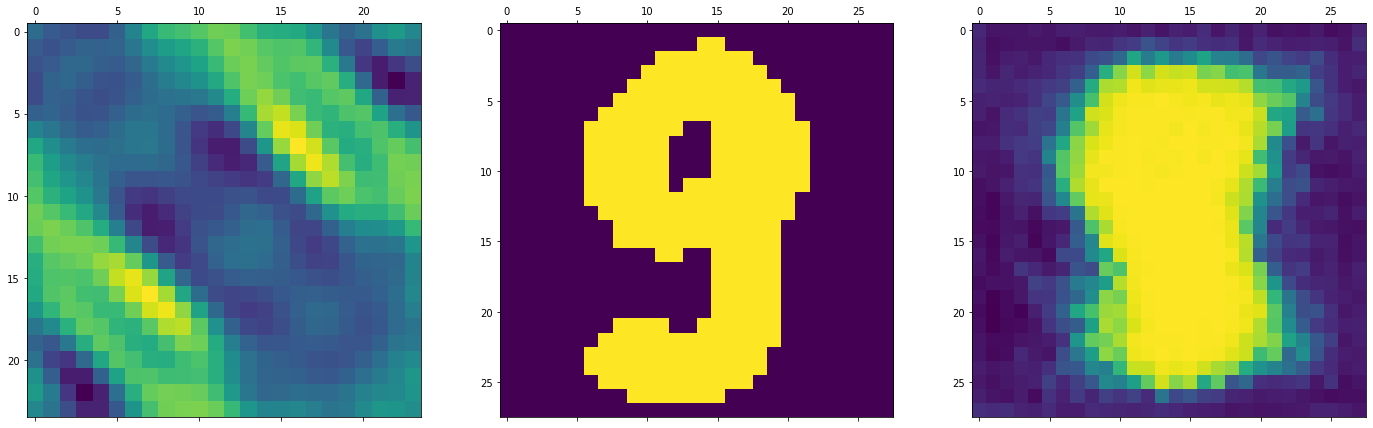

In [24]:
fig, axs = plt.subplots(1, 3, figsize=(24, 24))

axs[0].matshow(fieldMNIST_test[5])
axs[1].matshow(targetMNIST_test[5])
axs[2].matshow(pred1[5])

plt.show()

In [23]:
# trained_model_padded.evaluate(fieldMNIST_test_padded, targetMNIST_test)
model_mnist_padded.evaluate(fieldMNIST_test_padded, targetMNIST_test)

4/4 [==============================] - 1s 135ms/step - loss: 0.1099 - accuracy: 0.8606


[0.10985703021287918, 0.860615074634552]

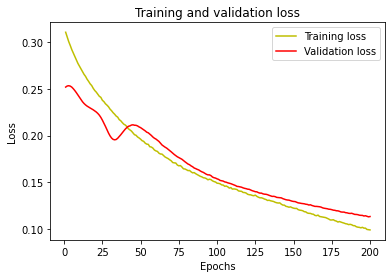

In [19]:
loss = hist_padded.history['loss']
val_loss = hist_padded.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

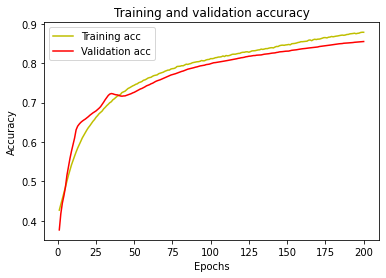

In [20]:
acc = hist_padded.history['accuracy']
val_acc = hist_padded.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

UNET with Flatten Layer to output 28x28 image

In [19]:
def unet_with_flatten(input_shape):
    inputs = Input(input_shape)

    conv1 = Conv2D(64, 3, padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)
    conv1 = Conv2D(64, 3, padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)
    conv1 = Conv2D(64, 3, padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Activation('relu')(conv2)
    conv2 = Conv2D(128, 3, padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    conv2 = Activation('relu')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    # Bottleneck
    bottleneck = Conv2D(256, 3, padding='same')(pool2)
    bottleneck = BatchNormalization()(bottleneck)
    bottleneck = Activation('relu')(bottleneck)
    bottleneck = Conv2D(256, 3, padding='same')(bottleneck)
    bottleneck = BatchNormalization()(bottleneck)
    bottleneck = Activation('relu')(bottleneck)

    # Expansive Path
    up1 = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same')(bottleneck)
    skip1 = Concatenate(axis=-1)([conv2, up1])
    conv3 = Conv2D(128, 3, padding='same')(skip1)
    conv3 = BatchNormalization()(conv3)
    conv3 = Activation('relu')(conv3)
    conv3 = Conv2D(128, 3, padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv3 = Activation('relu')(conv3)

    up2 = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same')(conv3)
    skip2 = Concatenate(axis=-1)([conv1, up2])
    conv4 = Conv2D(64, 3, padding='same')(skip2)
    conv4 = BatchNormalization()(conv4)
    conv4 = Activation('relu')(conv4)
    conv4 = Conv2D(64, 3, padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    conv4 = Activation('relu')(conv4)

    flatten = Flatten()(conv4)

    dense = Dense(28*28*1, activation='relu')(flatten)

    reshape = Reshape((28, 28, 1))(dense)

    # up3 = Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same')(conv4)
    # conv5 = Conv2D(32, 3, padding='same')(up3)
    # conv5 = BatchNormalization()(conv5)
    # conv5 = Activation('relu')(conv5)
    # conv5 = Conv2D(32, 3, padding='same')(conv5)
    # conv5 = BatchNormalization()(conv5)
    # conv5 = Activation('relu')(conv5)

    # conv5 = Conv2DTranspose(1, (3, 3), strides=(2, 2), padding='same')(conv4)

    output = Conv2D(1, 1, activation='sigmoid')(reshape)

    # Cropping to the desired size (35, 35)
    # cropped_output = Cropping2D(((7, 6), (7, 6)))(output)

    model = Model(inputs=inputs, outputs=output)

    return model

In [20]:
inputMNIST_shape = fieldMNIST_train.shape[1:]
model_mnist_flatten = unet_with_flatten(inputMNIST_shape)
model_mnist_flatten.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 24, 24, 1)]  0           []                               
                                                                                                  
 conv2d_12 (Conv2D)             (None, 24, 24, 64)   640         ['input_2[0][0]']                
                                                                                                  
 batch_normalization_11 (BatchN  (None, 24, 24, 64)  256         ['conv2d_12[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_11 (Activation)     (None, 24, 24, 64)   0           ['batch_normalization_11[0]

In [21]:
checkpoint2 = tf.keras.callbacks.ModelCheckpoint("./model_weights_flatten/", monitor="val_loss", mode="min", save_best_only=True, 
                                                verbose=1, overwrite=True)
earlyStop2 = EarlyStopping(monitor='loss',patience=5)

model_mnist_flatten.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=init_lr), loss = 'binary_crossentropy', 
                    metrics = 'accuracy')
hist_flatten = model_mnist_flatten.fit(x = fieldMNIST_train, y = targetMNIST_train, validation_data=(fieldMNIST_val, targetMNIST_val), 
                       batch_size = 20, epochs = total_epoch, callbacks = [earlyStop2, checkpoint2])

Epoch 1/200
21/21 [==============================] - ETA: 0s - loss: 0.6671 - accuracy: 0.7499
Epoch 1: val_loss improved from inf to 0.68925, saving model to ./model_weights_flatten\


INFO:tensorflow:Assets written to: ./model_weights_flatten\assets


INFO:tensorflow:Assets written to: ./model_weights_flatten\assets


21/21 [==============================] - 24s 1s/step - loss: 0.6671 - accuracy: 0.7499 - val_loss: 0.6893 - val_accuracy: 0.6872
Epoch 2/200
21/21 [==============================] - ETA: 0s - loss: 0.6285 - accuracy: 0.7963
Epoch 2: val_loss improved from 0.68925 to 0.68434, saving model to ./model_weights_flatten\


INFO:tensorflow:Assets written to: ./model_weights_flatten\assets


INFO:tensorflow:Assets written to: ./model_weights_flatten\assets


21/21 [==============================] - 19s 924ms/step - loss: 0.6285 - accuracy: 0.7963 - val_loss: 0.6843 - val_accuracy: 0.6944
Epoch 3/200
21/21 [==============================] - ETA: 0s - loss: 0.6085 - accuracy: 0.8110
Epoch 3: val_loss improved from 0.68434 to 0.68058, saving model to ./model_weights_flatten\


INFO:tensorflow:Assets written to: ./model_weights_flatten\assets


INFO:tensorflow:Assets written to: ./model_weights_flatten\assets


21/21 [==============================] - 17s 831ms/step - loss: 0.6085 - accuracy: 0.8110 - val_loss: 0.6806 - val_accuracy: 0.6909
Epoch 4/200
21/21 [==============================] - ETA: 0s - loss: 0.5942 - accuracy: 0.8184
Epoch 4: val_loss improved from 0.68058 to 0.67674, saving model to ./model_weights_flatten\


INFO:tensorflow:Assets written to: ./model_weights_flatten\assets


INFO:tensorflow:Assets written to: ./model_weights_flatten\assets


21/21 [==============================] - 16s 795ms/step - loss: 0.5942 - accuracy: 0.8184 - val_loss: 0.6767 - val_accuracy: 0.6938
Epoch 5/200
21/21 [==============================] - ETA: 0s - loss: 0.5804 - accuracy: 0.8243
Epoch 5: val_loss improved from 0.67674 to 0.67514, saving model to ./model_weights_flatten\


INFO:tensorflow:Assets written to: ./model_weights_flatten\assets


INFO:tensorflow:Assets written to: ./model_weights_flatten\assets


21/21 [==============================] - 17s 817ms/step - loss: 0.5804 - accuracy: 0.8243 - val_loss: 0.6751 - val_accuracy: 0.6937
Epoch 6/200
21/21 [==============================] - ETA: 0s - loss: 0.5698 - accuracy: 0.8284
Epoch 6: val_loss improved from 0.67514 to 0.67496, saving model to ./model_weights_flatten\


INFO:tensorflow:Assets written to: ./model_weights_flatten\assets


INFO:tensorflow:Assets written to: ./model_weights_flatten\assets


21/21 [==============================] - 16s 775ms/step - loss: 0.5698 - accuracy: 0.8284 - val_loss: 0.6750 - val_accuracy: 0.6954
Epoch 7/200
21/21 [==============================] - ETA: 0s - loss: 0.5591 - accuracy: 0.8326
Epoch 7: val_loss improved from 0.67496 to 0.67457, saving model to ./model_weights_flatten\


INFO:tensorflow:Assets written to: ./model_weights_flatten\assets


INFO:tensorflow:Assets written to: ./model_weights_flatten\assets


21/21 [==============================] - 17s 835ms/step - loss: 0.5591 - accuracy: 0.8326 - val_loss: 0.6746 - val_accuracy: 0.6956
Epoch 8/200
21/21 [==============================] - ETA: 0s - loss: 0.5510 - accuracy: 0.8353
Epoch 8: val_loss did not improve from 0.67457
21/21 [==============================] - 12s 571ms/step - loss: 0.5510 - accuracy: 0.8353 - val_loss: 0.6764 - val_accuracy: 0.6951
Epoch 9/200
21/21 [==============================] - ETA: 0s - loss: 0.5434 - accuracy: 0.8372
Epoch 9: val_loss did not improve from 0.67457
21/21 [==============================] - 13s 612ms/step - loss: 0.5434 - accuracy: 0.8372 - val_loss: 0.6859 - val_accuracy: 0.6959
Epoch 10/200
21/21 [==============================] - ETA: 0s - loss: 0.5364 - accuracy: 0.8398
Epoch 10: val_loss did not improve from 0.67457
21/21 [==============================] - 12s 561ms/step - loss: 0.5364 - accuracy: 0.8398 - val_loss: 0.6811 - val_accuracy: 0.6958
Epoch 11/200
21/21 [========================

INFO:tensorflow:Assets written to: ./model_weights_flatten\assets


INFO:tensorflow:Assets written to: ./model_weights_flatten\assets


21/21 [==============================] - 17s 827ms/step - loss: 0.4860 - accuracy: 0.8471 - val_loss: 0.6614 - val_accuracy: 0.7132
Epoch 22/200
21/21 [==============================] - ETA: 0s - loss: 0.4831 - accuracy: 0.8471
Epoch 22: val_loss did not improve from 0.66143
21/21 [==============================] - 14s 666ms/step - loss: 0.4831 - accuracy: 0.8471 - val_loss: 0.6644 - val_accuracy: 0.7163
Epoch 23/200
21/21 [==============================] - ETA: 0s - loss: 0.4806 - accuracy: 0.8468
Epoch 23: val_loss improved from 0.66143 to 0.65872, saving model to ./model_weights_flatten\


INFO:tensorflow:Assets written to: ./model_weights_flatten\assets


INFO:tensorflow:Assets written to: ./model_weights_flatten\assets


21/21 [==============================] - 22s 1s/step - loss: 0.4806 - accuracy: 0.8468 - val_loss: 0.6587 - val_accuracy: 0.7199
Epoch 24/200
21/21 [==============================] - ETA: 0s - loss: 0.4785 - accuracy: 0.8462
Epoch 24: val_loss improved from 0.65872 to 0.65152, saving model to ./model_weights_flatten\


INFO:tensorflow:Assets written to: ./model_weights_flatten\assets


INFO:tensorflow:Assets written to: ./model_weights_flatten\assets


21/21 [==============================] - 17s 849ms/step - loss: 0.4785 - accuracy: 0.8462 - val_loss: 0.6515 - val_accuracy: 0.7260
Epoch 25/200
21/21 [==============================] - ETA: 0s - loss: 0.4746 - accuracy: 0.8469
Epoch 25: val_loss improved from 0.65152 to 0.63410, saving model to ./model_weights_flatten\


INFO:tensorflow:Assets written to: ./model_weights_flatten\assets


INFO:tensorflow:Assets written to: ./model_weights_flatten\assets


21/21 [==============================] - 18s 895ms/step - loss: 0.4746 - accuracy: 0.8469 - val_loss: 0.6341 - val_accuracy: 0.7302
Epoch 26/200
21/21 [==============================] - ETA: 0s - loss: 0.4707 - accuracy: 0.8477
Epoch 26: val_loss improved from 0.63410 to 0.62820, saving model to ./model_weights_flatten\


INFO:tensorflow:Assets written to: ./model_weights_flatten\assets


INFO:tensorflow:Assets written to: ./model_weights_flatten\assets


21/21 [==============================] - 20s 960ms/step - loss: 0.4707 - accuracy: 0.8477 - val_loss: 0.6282 - val_accuracy: 0.7421
Epoch 27/200
21/21 [==============================] - ETA: 0s - loss: 0.4671 - accuracy: 0.8482
Epoch 27: val_loss improved from 0.62820 to 0.60946, saving model to ./model_weights_flatten\


INFO:tensorflow:Assets written to: ./model_weights_flatten\assets


INFO:tensorflow:Assets written to: ./model_weights_flatten\assets


21/21 [==============================] - 21s 996ms/step - loss: 0.4671 - accuracy: 0.8482 - val_loss: 0.6095 - val_accuracy: 0.7545
Epoch 28/200
21/21 [==============================] - ETA: 0s - loss: 0.4643 - accuracy: 0.8484
Epoch 28: val_loss improved from 0.60946 to 0.60116, saving model to ./model_weights_flatten\


INFO:tensorflow:Assets written to: ./model_weights_flatten\assets


INFO:tensorflow:Assets written to: ./model_weights_flatten\assets


21/21 [==============================] - 23s 1s/step - loss: 0.4643 - accuracy: 0.8484 - val_loss: 0.6012 - val_accuracy: 0.7638
Epoch 29/200
21/21 [==============================] - ETA: 0s - loss: 0.4628 - accuracy: 0.8477
Epoch 29: val_loss did not improve from 0.60116
21/21 [==============================] - 13s 621ms/step - loss: 0.4628 - accuracy: 0.8477 - val_loss: 0.6051 - val_accuracy: 0.7679
Epoch 30/200
21/21 [==============================] - ETA: 0s - loss: 0.4597 - accuracy: 0.8482
Epoch 30: val_loss improved from 0.60116 to 0.58413, saving model to ./model_weights_flatten\


INFO:tensorflow:Assets written to: ./model_weights_flatten\assets


INFO:tensorflow:Assets written to: ./model_weights_flatten\assets


21/21 [==============================] - 19s 937ms/step - loss: 0.4597 - accuracy: 0.8482 - val_loss: 0.5841 - val_accuracy: 0.7738
Epoch 31/200
21/21 [==============================] - ETA: 0s - loss: 0.4569 - accuracy: 0.8484
Epoch 31: val_loss improved from 0.58413 to 0.56499, saving model to ./model_weights_flatten\


INFO:tensorflow:Assets written to: ./model_weights_flatten\assets


INFO:tensorflow:Assets written to: ./model_weights_flatten\assets


21/21 [==============================] - 18s 857ms/step - loss: 0.4569 - accuracy: 0.8484 - val_loss: 0.5650 - val_accuracy: 0.7921
Epoch 32/200
21/21 [==============================] - ETA: 0s - loss: 0.4545 - accuracy: 0.8485
Epoch 32: val_loss improved from 0.56499 to 0.56047, saving model to ./model_weights_flatten\


INFO:tensorflow:Assets written to: ./model_weights_flatten\assets


INFO:tensorflow:Assets written to: ./model_weights_flatten\assets


21/21 [==============================] - 19s 930ms/step - loss: 0.4545 - accuracy: 0.8485 - val_loss: 0.5605 - val_accuracy: 0.8020
Epoch 33/200
21/21 [==============================] - ETA: 0s - loss: 0.4527 - accuracy: 0.8483
Epoch 33: val_loss improved from 0.56047 to 0.56043, saving model to ./model_weights_flatten\


INFO:tensorflow:Assets written to: ./model_weights_flatten\assets


INFO:tensorflow:Assets written to: ./model_weights_flatten\assets


21/21 [==============================] - 21s 1s/step - loss: 0.4527 - accuracy: 0.8483 - val_loss: 0.5604 - val_accuracy: 0.8079
Epoch 34/200
21/21 [==============================] - ETA: 0s - loss: 0.4501 - accuracy: 0.8486
Epoch 34: val_loss did not improve from 0.56043
21/21 [==============================] - 16s 772ms/step - loss: 0.4501 - accuracy: 0.8486 - val_loss: 0.5613 - val_accuracy: 0.8113
Epoch 35/200
21/21 [==============================] - ETA: 0s - loss: 0.4478 - accuracy: 0.8487
Epoch 35: val_loss improved from 0.56043 to 0.55083, saving model to ./model_weights_flatten\


INFO:tensorflow:Assets written to: ./model_weights_flatten\assets


INFO:tensorflow:Assets written to: ./model_weights_flatten\assets


21/21 [==============================] - 21s 1s/step - loss: 0.4478 - accuracy: 0.8487 - val_loss: 0.5508 - val_accuracy: 0.8116
Epoch 36/200
21/21 [==============================] - ETA: 0s - loss: 0.4456 - accuracy: 0.8488
Epoch 36: val_loss did not improve from 0.55083
21/21 [==============================] - 15s 717ms/step - loss: 0.4456 - accuracy: 0.8488 - val_loss: 0.5513 - val_accuracy: 0.8105
Epoch 37/200
21/21 [==============================] - ETA: 0s - loss: 0.4442 - accuracy: 0.8484
Epoch 37: val_loss did not improve from 0.55083
21/21 [==============================] - 14s 682ms/step - loss: 0.4442 - accuracy: 0.8484 - val_loss: 0.5697 - val_accuracy: 0.8121
Epoch 38/200
21/21 [==============================] - ETA: 0s - loss: 0.4418 - accuracy: 0.8488
Epoch 38: val_loss did not improve from 0.55083
21/21 [==============================] - 13s 641ms/step - loss: 0.4418 - accuracy: 0.8488 - val_loss: 0.5608 - val_accuracy: 0.8127
Epoch 39/200
21/21 [=======================

INFO:tensorflow:Assets written to: ./model_weights_flatten\assets


INFO:tensorflow:Assets written to: ./model_weights_flatten\assets


21/21 [==============================] - 18s 861ms/step - loss: 0.4083 - accuracy: 0.8488 - val_loss: 0.5490 - val_accuracy: 0.8136
Epoch 67/200
21/21 [==============================] - ETA: 0s - loss: 0.4072 - accuracy: 0.8491
Epoch 67: val_loss did not improve from 0.54897
21/21 [==============================] - 13s 612ms/step - loss: 0.4072 - accuracy: 0.8491 - val_loss: 0.5577 - val_accuracy: 0.8126
Epoch 68/200
21/21 [==============================] - ETA: 0s - loss: 0.4062 - accuracy: 0.8493
Epoch 68: val_loss did not improve from 0.54897
21/21 [==============================] - 12s 573ms/step - loss: 0.4062 - accuracy: 0.8493 - val_loss: 0.5660 - val_accuracy: 0.8139
Epoch 69/200
21/21 [==============================] - ETA: 0s - loss: 0.4052 - accuracy: 0.8495
Epoch 69: val_loss did not improve from 0.54897
21/21 [==============================] - 12s 551ms/step - loss: 0.4052 - accuracy: 0.8495 - val_loss: 0.5818 - val_accuracy: 0.8144
Epoch 70/200
21/21 [====================

In [22]:
model_mnist_flatten.save('unet_flatten.h5', overwrite=True)

trained_model_flatten = load_model('unet_flatten.h5')

In [25]:
pred2 = trained_model_flatten.predict(fieldMNIST_test)

4/4 [==============================] - 1s 107ms/step


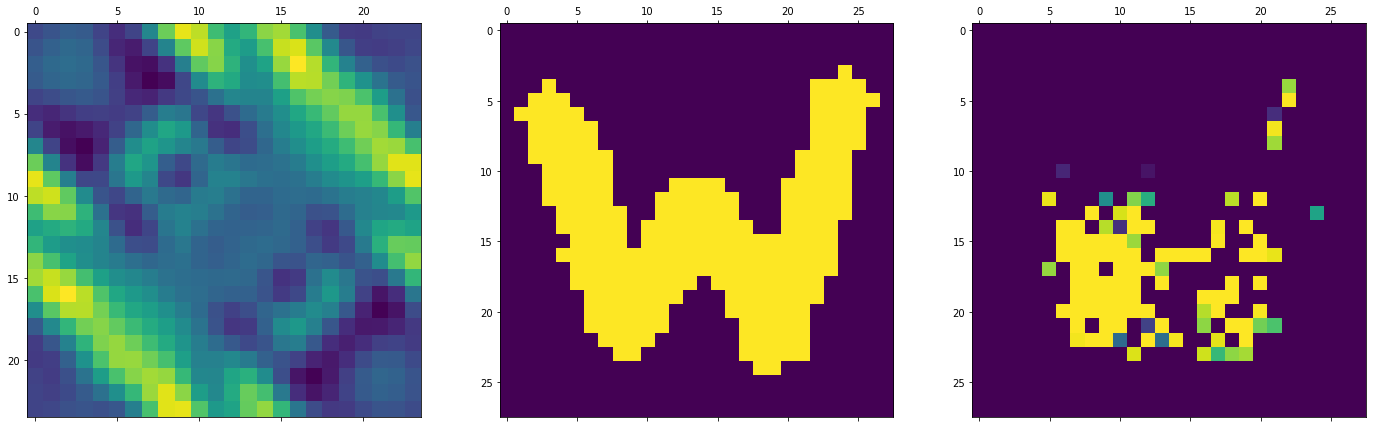

In [28]:
fig, axs = plt.subplots(1, 3, figsize=(24, 24))

axs[0].matshow(fieldMNIST_test[0])
axs[1].matshow(targetMNIST_test[0])
axs[2].matshow(pred2[0])

plt.show()

In [23]:
trained_model_flatten.evaluate(fieldMNIST_test, targetMNIST_test)

4/4 [==============================] - 3s 116ms/step - loss: 0.5876 - accuracy: 0.8151


[0.5875673890113831, 0.8150712847709656]

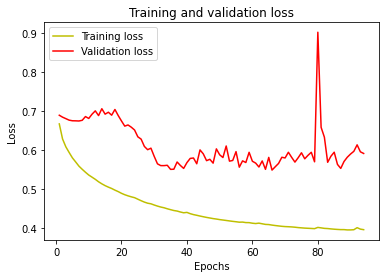

In [29]:
loss = hist_flatten.history['loss']
val_loss = hist_flatten.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

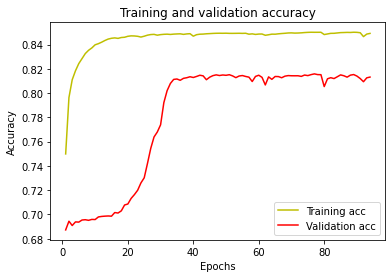

In [30]:
acc = hist_flatten.history['accuracy']
val_acc = hist_flatten.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Parameter search for both models

In [31]:
from sklearn.model_selection import GridSearchCV

In [39]:
model_mnist_padded.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=1e-6), loss = 'binary_crossentropy', 
                    metrics = 'accuracy')
hist_padded2 = model_mnist_padded.fit(x = fieldMNIST_train_padded, y = targetMNIST_train, 
                                    validation_data=(fieldMNIST_val_padded, targetMNIST_val), 
                                    batch_size = 10, epochs = total_epoch, 
                                    callbacks = [EarlyStopping(monitor='loss',patience=3), 
                                                tf.keras.callbacks.ModelCheckpoint("./model_weights2/", monitor="val_loss", mode="min", 
                                                                                   save_best_only=True, verbose=1, overwrite=True)])

Epoch 1/200
41/41 [==============================] - ETA: 0s - loss: 0.7590 - accuracy: 0.4844
Epoch 1: val_loss improved from inf to 0.70357, saving model to ./model_weights2\


INFO:tensorflow:Assets written to: ./model_weights2\assets


INFO:tensorflow:Assets written to: ./model_weights2\assets


41/41 [==============================] - 19s 386ms/step - loss: 0.7590 - accuracy: 0.4844 - val_loss: 0.7036 - val_accuracy: 0.3593
Epoch 2/200
41/41 [==============================] - ETA: 0s - loss: 0.7400 - accuracy: 0.5088
Epoch 2: val_loss improved from 0.70357 to 0.70310, saving model to ./model_weights2\


INFO:tensorflow:Assets written to: ./model_weights2\assets


INFO:tensorflow:Assets written to: ./model_weights2\assets


41/41 [==============================] - 16s 385ms/step - loss: 0.7400 - accuracy: 0.5088 - val_loss: 0.7031 - val_accuracy: 0.4292
Epoch 3/200
41/41 [==============================] - ETA: 0s - loss: 0.7236 - accuracy: 0.5341
Epoch 3: val_loss improved from 0.70310 to 0.69536, saving model to ./model_weights2\


INFO:tensorflow:Assets written to: ./model_weights2\assets


INFO:tensorflow:Assets written to: ./model_weights2\assets


41/41 [==============================] - 18s 436ms/step - loss: 0.7236 - accuracy: 0.5341 - val_loss: 0.6954 - val_accuracy: 0.4824
Epoch 4/200
41/41 [==============================] - ETA: 0s - loss: 0.7087 - accuracy: 0.5574
Epoch 4: val_loss improved from 0.69536 to 0.68422, saving model to ./model_weights2\


INFO:tensorflow:Assets written to: ./model_weights2\assets


INFO:tensorflow:Assets written to: ./model_weights2\assets


41/41 [==============================] - 20s 492ms/step - loss: 0.7087 - accuracy: 0.5574 - val_loss: 0.6842 - val_accuracy: 0.5385
Epoch 5/200
41/41 [==============================] - ETA: 0s - loss: 0.6952 - accuracy: 0.5795
Epoch 5: val_loss improved from 0.68422 to 0.67186, saving model to ./model_weights2\


INFO:tensorflow:Assets written to: ./model_weights2\assets


INFO:tensorflow:Assets written to: ./model_weights2\assets


41/41 [==============================] - 17s 424ms/step - loss: 0.6952 - accuracy: 0.5795 - val_loss: 0.6719 - val_accuracy: 0.6041
Epoch 6/200
41/41 [==============================] - ETA: 0s - loss: 0.6829 - accuracy: 0.5988
Epoch 6: val_loss improved from 0.67186 to 0.66045, saving model to ./model_weights2\


INFO:tensorflow:Assets written to: ./model_weights2\assets


INFO:tensorflow:Assets written to: ./model_weights2\assets


41/41 [==============================] - 19s 475ms/step - loss: 0.6829 - accuracy: 0.5988 - val_loss: 0.6604 - val_accuracy: 0.6406
Epoch 7/200
41/41 [==============================] - ETA: 0s - loss: 0.6717 - accuracy: 0.6146
Epoch 7: val_loss improved from 0.66045 to 0.65139, saving model to ./model_weights2\


INFO:tensorflow:Assets written to: ./model_weights2\assets


INFO:tensorflow:Assets written to: ./model_weights2\assets


41/41 [==============================] - 17s 408ms/step - loss: 0.6717 - accuracy: 0.6146 - val_loss: 0.6514 - val_accuracy: 0.6611
Epoch 8/200
41/41 [==============================] - ETA: 0s - loss: 0.6615 - accuracy: 0.6290
Epoch 8: val_loss improved from 0.65139 to 0.64417, saving model to ./model_weights2\


INFO:tensorflow:Assets written to: ./model_weights2\assets


INFO:tensorflow:Assets written to: ./model_weights2\assets


41/41 [==============================] - 17s 414ms/step - loss: 0.6615 - accuracy: 0.6290 - val_loss: 0.6442 - val_accuracy: 0.6717
Epoch 9/200
41/41 [==============================] - ETA: 0s - loss: 0.6517 - accuracy: 0.6402
Epoch 9: val_loss improved from 0.64417 to 0.63939, saving model to ./model_weights2\


INFO:tensorflow:Assets written to: ./model_weights2\assets


INFO:tensorflow:Assets written to: ./model_weights2\assets


41/41 [==============================] - 21s 504ms/step - loss: 0.6517 - accuracy: 0.6402 - val_loss: 0.6394 - val_accuracy: 0.6748
Epoch 10/200
41/41 [==============================] - ETA: 0s - loss: 0.6437 - accuracy: 0.6504
Epoch 10: val_loss improved from 0.63939 to 0.63686, saving model to ./model_weights2\


INFO:tensorflow:Assets written to: ./model_weights2\assets


INFO:tensorflow:Assets written to: ./model_weights2\assets


41/41 [==============================] - 20s 489ms/step - loss: 0.6437 - accuracy: 0.6504 - val_loss: 0.6369 - val_accuracy: 0.6756
Epoch 11/200
41/41 [==============================] - ETA: 0s - loss: 0.6363 - accuracy: 0.6602
Epoch 11: val_loss improved from 0.63686 to 0.63540, saving model to ./model_weights2\


INFO:tensorflow:Assets written to: ./model_weights2\assets


INFO:tensorflow:Assets written to: ./model_weights2\assets


41/41 [==============================] - 24s 597ms/step - loss: 0.6363 - accuracy: 0.6602 - val_loss: 0.6354 - val_accuracy: 0.6758
Epoch 12/200
41/41 [==============================] - ETA: 0s - loss: 0.6285 - accuracy: 0.6685
Epoch 12: val_loss improved from 0.63540 to 0.63321, saving model to ./model_weights2\


INFO:tensorflow:Assets written to: ./model_weights2\assets


INFO:tensorflow:Assets written to: ./model_weights2\assets


41/41 [==============================] - 23s 554ms/step - loss: 0.6285 - accuracy: 0.6685 - val_loss: 0.6332 - val_accuracy: 0.6758
Epoch 13/200
41/41 [==============================] - ETA: 0s - loss: 0.6213 - accuracy: 0.6769
Epoch 13: val_loss improved from 0.63321 to 0.62790, saving model to ./model_weights2\


INFO:tensorflow:Assets written to: ./model_weights2\assets


INFO:tensorflow:Assets written to: ./model_weights2\assets


41/41 [==============================] - 17s 428ms/step - loss: 0.6213 - accuracy: 0.6769 - val_loss: 0.6279 - val_accuracy: 0.6768
Epoch 14/200
41/41 [==============================] - ETA: 0s - loss: 0.6147 - accuracy: 0.6829
Epoch 14: val_loss improved from 0.62790 to 0.61822, saving model to ./model_weights2\


INFO:tensorflow:Assets written to: ./model_weights2\assets


INFO:tensorflow:Assets written to: ./model_weights2\assets


41/41 [==============================] - 18s 431ms/step - loss: 0.6147 - accuracy: 0.6829 - val_loss: 0.6182 - val_accuracy: 0.6802
Epoch 15/200
41/41 [==============================] - ETA: 0s - loss: 0.6099 - accuracy: 0.6888
Epoch 15: val_loss improved from 0.61822 to 0.60531, saving model to ./model_weights2\


INFO:tensorflow:Assets written to: ./model_weights2\assets


INFO:tensorflow:Assets written to: ./model_weights2\assets


41/41 [==============================] - 19s 463ms/step - loss: 0.6099 - accuracy: 0.6888 - val_loss: 0.6053 - val_accuracy: 0.6856
Epoch 16/200
41/41 [==============================] - ETA: 0s - loss: 0.6028 - accuracy: 0.6951
Epoch 16: val_loss improved from 0.60531 to 0.59301, saving model to ./model_weights2\


INFO:tensorflow:Assets written to: ./model_weights2\assets


INFO:tensorflow:Assets written to: ./model_weights2\assets


41/41 [==============================] - 23s 571ms/step - loss: 0.6028 - accuracy: 0.6951 - val_loss: 0.5930 - val_accuracy: 0.6926
Epoch 17/200
41/41 [==============================] - ETA: 0s - loss: 0.5958 - accuracy: 0.7017
Epoch 17: val_loss improved from 0.59301 to 0.58347, saving model to ./model_weights2\


INFO:tensorflow:Assets written to: ./model_weights2\assets


INFO:tensorflow:Assets written to: ./model_weights2\assets


41/41 [==============================] - 24s 584ms/step - loss: 0.5958 - accuracy: 0.7017 - val_loss: 0.5835 - val_accuracy: 0.7019
Epoch 18/200
41/41 [==============================] - ETA: 0s - loss: 0.5908 - accuracy: 0.7062
Epoch 18: val_loss improved from 0.58347 to 0.57709, saving model to ./model_weights2\


INFO:tensorflow:Assets written to: ./model_weights2\assets


INFO:tensorflow:Assets written to: ./model_weights2\assets


41/41 [==============================] - 22s 533ms/step - loss: 0.5908 - accuracy: 0.7062 - val_loss: 0.5771 - val_accuracy: 0.7075
Epoch 19/200
41/41 [==============================] - ETA: 0s - loss: 0.5852 - accuracy: 0.7120
Epoch 19: val_loss improved from 0.57709 to 0.57330, saving model to ./model_weights2\


INFO:tensorflow:Assets written to: ./model_weights2\assets


INFO:tensorflow:Assets written to: ./model_weights2\assets


41/41 [==============================] - 22s 530ms/step - loss: 0.5852 - accuracy: 0.7120 - val_loss: 0.5733 - val_accuracy: 0.7131
Epoch 20/200
41/41 [==============================] - ETA: 0s - loss: 0.5804 - accuracy: 0.7150
Epoch 20: val_loss improved from 0.57330 to 0.57131, saving model to ./model_weights2\


INFO:tensorflow:Assets written to: ./model_weights2\assets


INFO:tensorflow:Assets written to: ./model_weights2\assets


41/41 [==============================] - 28s 688ms/step - loss: 0.5804 - accuracy: 0.7150 - val_loss: 0.5713 - val_accuracy: 0.7173
Epoch 21/200
41/41 [==============================] - ETA: 0s - loss: 0.5745 - accuracy: 0.7204
Epoch 21: val_loss improved from 0.57131 to 0.56981, saving model to ./model_weights2\


INFO:tensorflow:Assets written to: ./model_weights2\assets


INFO:tensorflow:Assets written to: ./model_weights2\assets


41/41 [==============================] - 36s 885ms/step - loss: 0.5745 - accuracy: 0.7204 - val_loss: 0.5698 - val_accuracy: 0.7200
Epoch 22/200
41/41 [==============================] - ETA: 0s - loss: 0.5698 - accuracy: 0.7242
Epoch 22: val_loss improved from 0.56981 to 0.56848, saving model to ./model_weights2\


INFO:tensorflow:Assets written to: ./model_weights2\assets


INFO:tensorflow:Assets written to: ./model_weights2\assets


41/41 [==============================] - 29s 721ms/step - loss: 0.5698 - accuracy: 0.7242 - val_loss: 0.5685 - val_accuracy: 0.7219
Epoch 23/200
41/41 [==============================] - ETA: 0s - loss: 0.5653 - accuracy: 0.7276
Epoch 23: val_loss improved from 0.56848 to 0.56617, saving model to ./model_weights2\


INFO:tensorflow:Assets written to: ./model_weights2\assets


INFO:tensorflow:Assets written to: ./model_weights2\assets


41/41 [==============================] - 20s 489ms/step - loss: 0.5653 - accuracy: 0.7276 - val_loss: 0.5662 - val_accuracy: 0.7242
Epoch 24/200
41/41 [==============================] - ETA: 0s - loss: 0.5614 - accuracy: 0.7315
Epoch 24: val_loss improved from 0.56617 to 0.56357, saving model to ./model_weights2\


INFO:tensorflow:Assets written to: ./model_weights2\assets


INFO:tensorflow:Assets written to: ./model_weights2\assets


41/41 [==============================] - 22s 537ms/step - loss: 0.5614 - accuracy: 0.7315 - val_loss: 0.5636 - val_accuracy: 0.7270
Epoch 25/200
41/41 [==============================] - ETA: 0s - loss: 0.5559 - accuracy: 0.7345
Epoch 25: val_loss improved from 0.56357 to 0.56092, saving model to ./model_weights2\


INFO:tensorflow:Assets written to: ./model_weights2\assets


INFO:tensorflow:Assets written to: ./model_weights2\assets


41/41 [==============================] - 19s 460ms/step - loss: 0.5559 - accuracy: 0.7345 - val_loss: 0.5609 - val_accuracy: 0.7287
Epoch 26/200
41/41 [==============================] - ETA: 0s - loss: 0.5519 - accuracy: 0.7375
Epoch 26: val_loss improved from 0.56092 to 0.55698, saving model to ./model_weights2\


INFO:tensorflow:Assets written to: ./model_weights2\assets


INFO:tensorflow:Assets written to: ./model_weights2\assets


41/41 [==============================] - 25s 606ms/step - loss: 0.5519 - accuracy: 0.7375 - val_loss: 0.5570 - val_accuracy: 0.7313
Epoch 27/200
41/41 [==============================] - ETA: 0s - loss: 0.5473 - accuracy: 0.7417
Epoch 27: val_loss improved from 0.55698 to 0.55434, saving model to ./model_weights2\


INFO:tensorflow:Assets written to: ./model_weights2\assets


INFO:tensorflow:Assets written to: ./model_weights2\assets


41/41 [==============================] - 19s 459ms/step - loss: 0.5473 - accuracy: 0.7417 - val_loss: 0.5543 - val_accuracy: 0.7333
Epoch 28/200
41/41 [==============================] - ETA: 0s - loss: 0.5437 - accuracy: 0.7436
Epoch 28: val_loss improved from 0.55434 to 0.55082, saving model to ./model_weights2\


INFO:tensorflow:Assets written to: ./model_weights2\assets


INFO:tensorflow:Assets written to: ./model_weights2\assets


41/41 [==============================] - 18s 453ms/step - loss: 0.5437 - accuracy: 0.7436 - val_loss: 0.5508 - val_accuracy: 0.7359
Epoch 29/200
41/41 [==============================] - ETA: 0s - loss: 0.5408 - accuracy: 0.7458
Epoch 29: val_loss improved from 0.55082 to 0.54672, saving model to ./model_weights2\


INFO:tensorflow:Assets written to: ./model_weights2\assets


INFO:tensorflow:Assets written to: ./model_weights2\assets


41/41 [==============================] - 18s 441ms/step - loss: 0.5408 - accuracy: 0.7458 - val_loss: 0.5467 - val_accuracy: 0.7390
Epoch 30/200
41/41 [==============================] - ETA: 0s - loss: 0.5355 - accuracy: 0.7494
Epoch 30: val_loss improved from 0.54672 to 0.54365, saving model to ./model_weights2\


INFO:tensorflow:Assets written to: ./model_weights2\assets


INFO:tensorflow:Assets written to: ./model_weights2\assets


41/41 [==============================] - 20s 493ms/step - loss: 0.5355 - accuracy: 0.7494 - val_loss: 0.5436 - val_accuracy: 0.7410
Epoch 31/200
41/41 [==============================] - ETA: 0s - loss: 0.5337 - accuracy: 0.7509
Epoch 31: val_loss improved from 0.54365 to 0.53922, saving model to ./model_weights2\


INFO:tensorflow:Assets written to: ./model_weights2\assets


INFO:tensorflow:Assets written to: ./model_weights2\assets


41/41 [==============================] - 29s 708ms/step - loss: 0.5337 - accuracy: 0.7509 - val_loss: 0.5392 - val_accuracy: 0.7436
Epoch 32/200
41/41 [==============================] - ETA: 0s - loss: 0.5283 - accuracy: 0.7547
Epoch 32: val_loss improved from 0.53922 to 0.53650, saving model to ./model_weights2\


INFO:tensorflow:Assets written to: ./model_weights2\assets


INFO:tensorflow:Assets written to: ./model_weights2\assets


41/41 [==============================] - 26s 643ms/step - loss: 0.5283 - accuracy: 0.7547 - val_loss: 0.5365 - val_accuracy: 0.7453
Epoch 33/200
41/41 [==============================] - ETA: 0s - loss: 0.5261 - accuracy: 0.7558
Epoch 33: val_loss improved from 0.53650 to 0.53236, saving model to ./model_weights2\


INFO:tensorflow:Assets written to: ./model_weights2\assets


INFO:tensorflow:Assets written to: ./model_weights2\assets


41/41 [==============================] - 24s 596ms/step - loss: 0.5261 - accuracy: 0.7558 - val_loss: 0.5324 - val_accuracy: 0.7482
Epoch 34/200
41/41 [==============================] - ETA: 0s - loss: 0.5223 - accuracy: 0.7583
Epoch 34: val_loss improved from 0.53236 to 0.52958, saving model to ./model_weights2\


INFO:tensorflow:Assets written to: ./model_weights2\assets


INFO:tensorflow:Assets written to: ./model_weights2\assets


41/41 [==============================] - 24s 589ms/step - loss: 0.5223 - accuracy: 0.7583 - val_loss: 0.5296 - val_accuracy: 0.7497
Epoch 35/200
41/41 [==============================] - ETA: 0s - loss: 0.5188 - accuracy: 0.7597
Epoch 35: val_loss improved from 0.52958 to 0.52702, saving model to ./model_weights2\


INFO:tensorflow:Assets written to: ./model_weights2\assets


INFO:tensorflow:Assets written to: ./model_weights2\assets


41/41 [==============================] - 24s 586ms/step - loss: 0.5188 - accuracy: 0.7597 - val_loss: 0.5270 - val_accuracy: 0.7507
Epoch 36/200
41/41 [==============================] - ETA: 0s - loss: 0.5166 - accuracy: 0.7614
Epoch 36: val_loss improved from 0.52702 to 0.52393, saving model to ./model_weights2\


INFO:tensorflow:Assets written to: ./model_weights2\assets


INFO:tensorflow:Assets written to: ./model_weights2\assets


41/41 [==============================] - 26s 625ms/step - loss: 0.5166 - accuracy: 0.7614 - val_loss: 0.5239 - val_accuracy: 0.7529
Epoch 37/200
41/41 [==============================] - ETA: 0s - loss: 0.5133 - accuracy: 0.7633
Epoch 37: val_loss improved from 0.52393 to 0.52088, saving model to ./model_weights2\


INFO:tensorflow:Assets written to: ./model_weights2\assets


INFO:tensorflow:Assets written to: ./model_weights2\assets


41/41 [==============================] - 24s 601ms/step - loss: 0.5133 - accuracy: 0.7633 - val_loss: 0.5209 - val_accuracy: 0.7547
Epoch 38/200
41/41 [==============================] - ETA: 0s - loss: 0.5106 - accuracy: 0.7642
Epoch 38: val_loss improved from 0.52088 to 0.51793, saving model to ./model_weights2\


INFO:tensorflow:Assets written to: ./model_weights2\assets


INFO:tensorflow:Assets written to: ./model_weights2\assets


41/41 [==============================] - 32s 777ms/step - loss: 0.5106 - accuracy: 0.7642 - val_loss: 0.5179 - val_accuracy: 0.7567
Epoch 39/200
41/41 [==============================] - ETA: 0s - loss: 0.5075 - accuracy: 0.7666
Epoch 39: val_loss improved from 0.51793 to 0.51469, saving model to ./model_weights2\


INFO:tensorflow:Assets written to: ./model_weights2\assets


INFO:tensorflow:Assets written to: ./model_weights2\assets


41/41 [==============================] - 32s 776ms/step - loss: 0.5075 - accuracy: 0.7666 - val_loss: 0.5147 - val_accuracy: 0.7586
Epoch 40/200
41/41 [==============================] - ETA: 0s - loss: 0.5041 - accuracy: 0.7690
Epoch 40: val_loss improved from 0.51469 to 0.51282, saving model to ./model_weights2\


INFO:tensorflow:Assets written to: ./model_weights2\assets


INFO:tensorflow:Assets written to: ./model_weights2\assets


41/41 [==============================] - 34s 836ms/step - loss: 0.5041 - accuracy: 0.7690 - val_loss: 0.5128 - val_accuracy: 0.7594
Epoch 41/200
41/41 [==============================] - ETA: 0s - loss: 0.5010 - accuracy: 0.7700
Epoch 41: val_loss improved from 0.51282 to 0.51054, saving model to ./model_weights2\


INFO:tensorflow:Assets written to: ./model_weights2\assets


INFO:tensorflow:Assets written to: ./model_weights2\assets


41/41 [==============================] - 25s 625ms/step - loss: 0.5010 - accuracy: 0.7700 - val_loss: 0.5105 - val_accuracy: 0.7611
Epoch 42/200
41/41 [==============================] - ETA: 0s - loss: 0.4986 - accuracy: 0.7716
Epoch 42: val_loss improved from 0.51054 to 0.50794, saving model to ./model_weights2\


INFO:tensorflow:Assets written to: ./model_weights2\assets


INFO:tensorflow:Assets written to: ./model_weights2\assets


41/41 [==============================] - 26s 629ms/step - loss: 0.4986 - accuracy: 0.7716 - val_loss: 0.5079 - val_accuracy: 0.7630
Epoch 43/200
41/41 [==============================] - ETA: 0s - loss: 0.4966 - accuracy: 0.7734
Epoch 43: val_loss improved from 0.50794 to 0.50511, saving model to ./model_weights2\


INFO:tensorflow:Assets written to: ./model_weights2\assets


INFO:tensorflow:Assets written to: ./model_weights2\assets


41/41 [==============================] - 26s 642ms/step - loss: 0.4966 - accuracy: 0.7734 - val_loss: 0.5051 - val_accuracy: 0.7650
Epoch 44/200
41/41 [==============================] - ETA: 0s - loss: 0.4941 - accuracy: 0.7737
Epoch 44: val_loss improved from 0.50511 to 0.50209, saving model to ./model_weights2\


INFO:tensorflow:Assets written to: ./model_weights2\assets


INFO:tensorflow:Assets written to: ./model_weights2\assets


41/41 [==============================] - 27s 676ms/step - loss: 0.4941 - accuracy: 0.7737 - val_loss: 0.5021 - val_accuracy: 0.7670
Epoch 45/200
41/41 [==============================] - ETA: 0s - loss: 0.4899 - accuracy: 0.7773
Epoch 45: val_loss improved from 0.50209 to 0.50004, saving model to ./model_weights2\


INFO:tensorflow:Assets written to: ./model_weights2\assets


INFO:tensorflow:Assets written to: ./model_weights2\assets


41/41 [==============================] - 35s 862ms/step - loss: 0.4899 - accuracy: 0.7773 - val_loss: 0.5000 - val_accuracy: 0.7681
Epoch 46/200
41/41 [==============================] - ETA: 0s - loss: 0.4866 - accuracy: 0.7786
Epoch 46: val_loss improved from 0.50004 to 0.49796, saving model to ./model_weights2\


INFO:tensorflow:Assets written to: ./model_weights2\assets


INFO:tensorflow:Assets written to: ./model_weights2\assets


41/41 [==============================] - 37s 911ms/step - loss: 0.4866 - accuracy: 0.7786 - val_loss: 0.4980 - val_accuracy: 0.7692
Epoch 47/200
41/41 [==============================] - ETA: 0s - loss: 0.4845 - accuracy: 0.7807
Epoch 47: val_loss improved from 0.49796 to 0.49566, saving model to ./model_weights2\


INFO:tensorflow:Assets written to: ./model_weights2\assets


INFO:tensorflow:Assets written to: ./model_weights2\assets


41/41 [==============================] - 33s 819ms/step - loss: 0.4845 - accuracy: 0.7807 - val_loss: 0.4957 - val_accuracy: 0.7702
Epoch 48/200
41/41 [==============================] - ETA: 0s - loss: 0.4830 - accuracy: 0.7812
Epoch 48: val_loss improved from 0.49566 to 0.49276, saving model to ./model_weights2\


INFO:tensorflow:Assets written to: ./model_weights2\assets


INFO:tensorflow:Assets written to: ./model_weights2\assets


41/41 [==============================] - 26s 649ms/step - loss: 0.4830 - accuracy: 0.7812 - val_loss: 0.4928 - val_accuracy: 0.7718
Epoch 49/200
41/41 [==============================] - ETA: 0s - loss: 0.4806 - accuracy: 0.7820
Epoch 49: val_loss improved from 0.49276 to 0.49046, saving model to ./model_weights2\


INFO:tensorflow:Assets written to: ./model_weights2\assets


INFO:tensorflow:Assets written to: ./model_weights2\assets


41/41 [==============================] - 27s 660ms/step - loss: 0.4806 - accuracy: 0.7820 - val_loss: 0.4905 - val_accuracy: 0.7730
Epoch 50/200
41/41 [==============================] - ETA: 0s - loss: 0.4771 - accuracy: 0.7842
Epoch 50: val_loss improved from 0.49046 to 0.48808, saving model to ./model_weights2\


INFO:tensorflow:Assets written to: ./model_weights2\assets


INFO:tensorflow:Assets written to: ./model_weights2\assets


41/41 [==============================] - 28s 690ms/step - loss: 0.4771 - accuracy: 0.7842 - val_loss: 0.4881 - val_accuracy: 0.7746
Epoch 51/200
41/41 [==============================] - ETA: 0s - loss: 0.4748 - accuracy: 0.7859
Epoch 51: val_loss improved from 0.48808 to 0.48637, saving model to ./model_weights2\


INFO:tensorflow:Assets written to: ./model_weights2\assets


INFO:tensorflow:Assets written to: ./model_weights2\assets


41/41 [==============================] - 25s 618ms/step - loss: 0.4748 - accuracy: 0.7859 - val_loss: 0.4864 - val_accuracy: 0.7758
Epoch 52/200
41/41 [==============================] - ETA: 0s - loss: 0.4728 - accuracy: 0.7868
Epoch 52: val_loss improved from 0.48637 to 0.48382, saving model to ./model_weights2\


INFO:tensorflow:Assets written to: ./model_weights2\assets


INFO:tensorflow:Assets written to: ./model_weights2\assets


41/41 [==============================] - 27s 676ms/step - loss: 0.4728 - accuracy: 0.7868 - val_loss: 0.4838 - val_accuracy: 0.7773
Epoch 53/200
41/41 [==============================] - ETA: 0s - loss: 0.4700 - accuracy: 0.7886
Epoch 53: val_loss improved from 0.48382 to 0.48157, saving model to ./model_weights2\


INFO:tensorflow:Assets written to: ./model_weights2\assets


INFO:tensorflow:Assets written to: ./model_weights2\assets


41/41 [==============================] - 26s 648ms/step - loss: 0.4700 - accuracy: 0.7886 - val_loss: 0.4816 - val_accuracy: 0.7788
Epoch 54/200
41/41 [==============================] - ETA: 0s - loss: 0.4678 - accuracy: 0.7898
Epoch 54: val_loss improved from 0.48157 to 0.48012, saving model to ./model_weights2\


INFO:tensorflow:Assets written to: ./model_weights2\assets


INFO:tensorflow:Assets written to: ./model_weights2\assets


41/41 [==============================] - 33s 810ms/step - loss: 0.4678 - accuracy: 0.7898 - val_loss: 0.4801 - val_accuracy: 0.7795
Epoch 55/200
41/41 [==============================] - ETA: 0s - loss: 0.4652 - accuracy: 0.7912
Epoch 55: val_loss improved from 0.48012 to 0.47744, saving model to ./model_weights2\


INFO:tensorflow:Assets written to: ./model_weights2\assets


INFO:tensorflow:Assets written to: ./model_weights2\assets


41/41 [==============================] - 18s 433ms/step - loss: 0.4652 - accuracy: 0.7912 - val_loss: 0.4774 - val_accuracy: 0.7812
Epoch 56/200
41/41 [==============================] - ETA: 0s - loss: 0.4625 - accuracy: 0.7929
Epoch 56: val_loss improved from 0.47744 to 0.47497, saving model to ./model_weights2\


INFO:tensorflow:Assets written to: ./model_weights2\assets


INFO:tensorflow:Assets written to: ./model_weights2\assets


41/41 [==============================] - 21s 507ms/step - loss: 0.4625 - accuracy: 0.7929 - val_loss: 0.4750 - val_accuracy: 0.7823
Epoch 57/200
41/41 [==============================] - ETA: 0s - loss: 0.4623 - accuracy: 0.7942
Epoch 57: val_loss improved from 0.47497 to 0.47238, saving model to ./model_weights2\


INFO:tensorflow:Assets written to: ./model_weights2\assets


INFO:tensorflow:Assets written to: ./model_weights2\assets


41/41 [==============================] - 32s 783ms/step - loss: 0.4623 - accuracy: 0.7942 - val_loss: 0.4724 - val_accuracy: 0.7836
Epoch 58/200
41/41 [==============================] - ETA: 0s - loss: 0.4586 - accuracy: 0.7955
Epoch 58: val_loss improved from 0.47238 to 0.46932, saving model to ./model_weights2\


INFO:tensorflow:Assets written to: ./model_weights2\assets


INFO:tensorflow:Assets written to: ./model_weights2\assets


41/41 [==============================] - 43s 1s/step - loss: 0.4586 - accuracy: 0.7955 - val_loss: 0.4693 - val_accuracy: 0.7854
Epoch 59/200
41/41 [==============================] - ETA: 0s - loss: 0.4540 - accuracy: 0.7987
Epoch 59: val_loss improved from 0.46932 to 0.46856, saving model to ./model_weights2\


INFO:tensorflow:Assets written to: ./model_weights2\assets


INFO:tensorflow:Assets written to: ./model_weights2\assets


41/41 [==============================] - 42s 1s/step - loss: 0.4540 - accuracy: 0.7987 - val_loss: 0.4686 - val_accuracy: 0.7861
Epoch 60/200
41/41 [==============================] - ETA: 0s - loss: 0.4535 - accuracy: 0.7986
Epoch 60: val_loss improved from 0.46856 to 0.46538, saving model to ./model_weights2\


INFO:tensorflow:Assets written to: ./model_weights2\assets


INFO:tensorflow:Assets written to: ./model_weights2\assets


41/41 [==============================] - 28s 693ms/step - loss: 0.4535 - accuracy: 0.7986 - val_loss: 0.4654 - val_accuracy: 0.7883
Epoch 61/200
41/41 [==============================] - ETA: 0s - loss: 0.4501 - accuracy: 0.8010
Epoch 61: val_loss improved from 0.46538 to 0.46374, saving model to ./model_weights2\


INFO:tensorflow:Assets written to: ./model_weights2\assets


INFO:tensorflow:Assets written to: ./model_weights2\assets


41/41 [==============================] - 27s 661ms/step - loss: 0.4501 - accuracy: 0.8010 - val_loss: 0.4637 - val_accuracy: 0.7897
Epoch 62/200
41/41 [==============================] - ETA: 0s - loss: 0.4484 - accuracy: 0.8025
Epoch 62: val_loss improved from 0.46374 to 0.46169, saving model to ./model_weights2\


INFO:tensorflow:Assets written to: ./model_weights2\assets


INFO:tensorflow:Assets written to: ./model_weights2\assets


41/41 [==============================] - 26s 631ms/step - loss: 0.4484 - accuracy: 0.8025 - val_loss: 0.4617 - val_accuracy: 0.7907
Epoch 63/200
41/41 [==============================] - ETA: 0s - loss: 0.4453 - accuracy: 0.8043
Epoch 63: val_loss improved from 0.46169 to 0.45954, saving model to ./model_weights2\


INFO:tensorflow:Assets written to: ./model_weights2\assets


INFO:tensorflow:Assets written to: ./model_weights2\assets


41/41 [==============================] - 24s 593ms/step - loss: 0.4453 - accuracy: 0.8043 - val_loss: 0.4595 - val_accuracy: 0.7921
Epoch 64/200
41/41 [==============================] - ETA: 0s - loss: 0.4428 - accuracy: 0.8055
Epoch 64: val_loss improved from 0.45954 to 0.45760, saving model to ./model_weights2\


INFO:tensorflow:Assets written to: ./model_weights2\assets


INFO:tensorflow:Assets written to: ./model_weights2\assets


41/41 [==============================] - 25s 602ms/step - loss: 0.4428 - accuracy: 0.8055 - val_loss: 0.4576 - val_accuracy: 0.7932
Epoch 65/200
41/41 [==============================] - ETA: 0s - loss: 0.4396 - accuracy: 0.8082
Epoch 65: val_loss improved from 0.45760 to 0.45582, saving model to ./model_weights2\


INFO:tensorflow:Assets written to: ./model_weights2\assets


INFO:tensorflow:Assets written to: ./model_weights2\assets


41/41 [==============================] - 20s 484ms/step - loss: 0.4396 - accuracy: 0.8082 - val_loss: 0.4558 - val_accuracy: 0.7946
Epoch 66/200
41/41 [==============================] - ETA: 0s - loss: 0.4375 - accuracy: 0.8093
Epoch 66: val_loss improved from 0.45582 to 0.45255, saving model to ./model_weights2\


INFO:tensorflow:Assets written to: ./model_weights2\assets


INFO:tensorflow:Assets written to: ./model_weights2\assets


41/41 [==============================] - 21s 524ms/step - loss: 0.4375 - accuracy: 0.8093 - val_loss: 0.4526 - val_accuracy: 0.7964
Epoch 67/200
41/41 [==============================] - ETA: 0s - loss: 0.4348 - accuracy: 0.8113
Epoch 67: val_loss improved from 0.45255 to 0.45159, saving model to ./model_weights2\


INFO:tensorflow:Assets written to: ./model_weights2\assets


INFO:tensorflow:Assets written to: ./model_weights2\assets


41/41 [==============================] - 22s 529ms/step - loss: 0.4348 - accuracy: 0.8113 - val_loss: 0.4516 - val_accuracy: 0.7973
Epoch 68/200
41/41 [==============================] - ETA: 0s - loss: 0.4315 - accuracy: 0.8127
Epoch 68: val_loss improved from 0.45159 to 0.45032, saving model to ./model_weights2\


INFO:tensorflow:Assets written to: ./model_weights2\assets


INFO:tensorflow:Assets written to: ./model_weights2\assets


41/41 [==============================] - 25s 608ms/step - loss: 0.4315 - accuracy: 0.8127 - val_loss: 0.4503 - val_accuracy: 0.7984
Epoch 69/200
41/41 [==============================] - ETA: 0s - loss: 0.4295 - accuracy: 0.8147
Epoch 69: val_loss improved from 0.45032 to 0.44607, saving model to ./model_weights2\


INFO:tensorflow:Assets written to: ./model_weights2\assets


INFO:tensorflow:Assets written to: ./model_weights2\assets


41/41 [==============================] - 19s 462ms/step - loss: 0.4295 - accuracy: 0.8147 - val_loss: 0.4461 - val_accuracy: 0.8011
Epoch 70/200
41/41 [==============================] - ETA: 0s - loss: 0.4268 - accuracy: 0.8156
Epoch 70: val_loss improved from 0.44607 to 0.44468, saving model to ./model_weights2\


INFO:tensorflow:Assets written to: ./model_weights2\assets


INFO:tensorflow:Assets written to: ./model_weights2\assets


41/41 [==============================] - 18s 448ms/step - loss: 0.4268 - accuracy: 0.8156 - val_loss: 0.4447 - val_accuracy: 0.8022
Epoch 71/200
41/41 [==============================] - ETA: 0s - loss: 0.4229 - accuracy: 0.8186
Epoch 71: val_loss improved from 0.44468 to 0.44203, saving model to ./model_weights2\


INFO:tensorflow:Assets written to: ./model_weights2\assets


INFO:tensorflow:Assets written to: ./model_weights2\assets


41/41 [==============================] - 18s 443ms/step - loss: 0.4229 - accuracy: 0.8186 - val_loss: 0.4420 - val_accuracy: 0.8038
Epoch 72/200
41/41 [==============================] - ETA: 0s - loss: 0.4213 - accuracy: 0.8199
Epoch 72: val_loss improved from 0.44203 to 0.44144, saving model to ./model_weights2\


INFO:tensorflow:Assets written to: ./model_weights2\assets


INFO:tensorflow:Assets written to: ./model_weights2\assets


41/41 [==============================] - 19s 457ms/step - loss: 0.4213 - accuracy: 0.8199 - val_loss: 0.4414 - val_accuracy: 0.8047
Epoch 73/200
41/41 [==============================] - ETA: 0s - loss: 0.4178 - accuracy: 0.8218
Epoch 73: val_loss improved from 0.44144 to 0.43801, saving model to ./model_weights2\


INFO:tensorflow:Assets written to: ./model_weights2\assets


INFO:tensorflow:Assets written to: ./model_weights2\assets


41/41 [==============================] - 31s 762ms/step - loss: 0.4178 - accuracy: 0.8218 - val_loss: 0.4380 - val_accuracy: 0.8067
Epoch 74/200
41/41 [==============================] - ETA: 0s - loss: 0.4164 - accuracy: 0.8234
Epoch 74: val_loss improved from 0.43801 to 0.43424, saving model to ./model_weights2\


INFO:tensorflow:Assets written to: ./model_weights2\assets


INFO:tensorflow:Assets written to: ./model_weights2\assets


41/41 [==============================] - 32s 798ms/step - loss: 0.4164 - accuracy: 0.8234 - val_loss: 0.4342 - val_accuracy: 0.8093
Epoch 75/200
41/41 [==============================] - ETA: 0s - loss: 0.4143 - accuracy: 0.8244
Epoch 75: val_loss improved from 0.43424 to 0.43177, saving model to ./model_weights2\


INFO:tensorflow:Assets written to: ./model_weights2\assets


INFO:tensorflow:Assets written to: ./model_weights2\assets


41/41 [==============================] - 29s 713ms/step - loss: 0.4143 - accuracy: 0.8244 - val_loss: 0.4318 - val_accuracy: 0.8106
Epoch 76/200
41/41 [==============================] - ETA: 0s - loss: 0.4105 - accuracy: 0.8263
Epoch 76: val_loss improved from 0.43177 to 0.43129, saving model to ./model_weights2\


INFO:tensorflow:Assets written to: ./model_weights2\assets


INFO:tensorflow:Assets written to: ./model_weights2\assets


41/41 [==============================] - 32s 798ms/step - loss: 0.4105 - accuracy: 0.8263 - val_loss: 0.4313 - val_accuracy: 0.8113
Epoch 77/200
41/41 [==============================] - ETA: 0s - loss: 0.4066 - accuracy: 0.8292
Epoch 77: val_loss improved from 0.43129 to 0.43118, saving model to ./model_weights2\


INFO:tensorflow:Assets written to: ./model_weights2\assets


INFO:tensorflow:Assets written to: ./model_weights2\assets


41/41 [==============================] - 30s 744ms/step - loss: 0.4066 - accuracy: 0.8292 - val_loss: 0.4312 - val_accuracy: 0.8118
Epoch 78/200
41/41 [==============================] - ETA: 0s - loss: 0.4038 - accuracy: 0.8309
Epoch 78: val_loss improved from 0.43118 to 0.42758, saving model to ./model_weights2\


INFO:tensorflow:Assets written to: ./model_weights2\assets


INFO:tensorflow:Assets written to: ./model_weights2\assets


41/41 [==============================] - 34s 831ms/step - loss: 0.4038 - accuracy: 0.8309 - val_loss: 0.4276 - val_accuracy: 0.8141
Epoch 79/200
41/41 [==============================] - ETA: 0s - loss: 0.4017 - accuracy: 0.8322
Epoch 79: val_loss improved from 0.42758 to 0.42569, saving model to ./model_weights2\


INFO:tensorflow:Assets written to: ./model_weights2\assets


INFO:tensorflow:Assets written to: ./model_weights2\assets


41/41 [==============================] - 28s 692ms/step - loss: 0.4017 - accuracy: 0.8322 - val_loss: 0.4257 - val_accuracy: 0.8154
Epoch 80/200
41/41 [==============================] - ETA: 0s - loss: 0.3996 - accuracy: 0.8332
Epoch 80: val_loss improved from 0.42569 to 0.42398, saving model to ./model_weights2\


INFO:tensorflow:Assets written to: ./model_weights2\assets


INFO:tensorflow:Assets written to: ./model_weights2\assets


41/41 [==============================] - 28s 681ms/step - loss: 0.3996 - accuracy: 0.8332 - val_loss: 0.4240 - val_accuracy: 0.8165
Epoch 81/200
41/41 [==============================] - ETA: 0s - loss: 0.3968 - accuracy: 0.8352
Epoch 81: val_loss improved from 0.42398 to 0.41873, saving model to ./model_weights2\


INFO:tensorflow:Assets written to: ./model_weights2\assets


INFO:tensorflow:Assets written to: ./model_weights2\assets


41/41 [==============================] - 25s 620ms/step - loss: 0.3968 - accuracy: 0.8352 - val_loss: 0.4187 - val_accuracy: 0.8192
Epoch 82/200
41/41 [==============================] - ETA: 0s - loss: 0.3943 - accuracy: 0.8367
Epoch 82: val_loss did not improve from 0.41873
41/41 [==============================] - 25s 620ms/step - loss: 0.3943 - accuracy: 0.8367 - val_loss: 0.4189 - val_accuracy: 0.8197
Epoch 83/200
41/41 [==============================] - ETA: 0s - loss: 0.3899 - accuracy: 0.8391
Epoch 83: val_loss improved from 0.41873 to 0.41682, saving model to ./model_weights2\


INFO:tensorflow:Assets written to: ./model_weights2\assets


INFO:tensorflow:Assets written to: ./model_weights2\assets


41/41 [==============================] - 33s 814ms/step - loss: 0.3899 - accuracy: 0.8391 - val_loss: 0.4168 - val_accuracy: 0.8210
Epoch 84/200
41/41 [==============================] - ETA: 0s - loss: 0.3883 - accuracy: 0.8404
Epoch 84: val_loss improved from 0.41682 to 0.41511, saving model to ./model_weights2\


INFO:tensorflow:Assets written to: ./model_weights2\assets


INFO:tensorflow:Assets written to: ./model_weights2\assets


41/41 [==============================] - 18s 435ms/step - loss: 0.3883 - accuracy: 0.8404 - val_loss: 0.4151 - val_accuracy: 0.8223
Epoch 85/200
41/41 [==============================] - ETA: 0s - loss: 0.3858 - accuracy: 0.8410
Epoch 85: val_loss improved from 0.41511 to 0.41109, saving model to ./model_weights2\


INFO:tensorflow:Assets written to: ./model_weights2\assets


INFO:tensorflow:Assets written to: ./model_weights2\assets


41/41 [==============================] - 18s 440ms/step - loss: 0.3858 - accuracy: 0.8410 - val_loss: 0.4111 - val_accuracy: 0.8249
Epoch 86/200
41/41 [==============================] - ETA: 0s - loss: 0.3835 - accuracy: 0.8433
Epoch 86: val_loss improved from 0.41109 to 0.41091, saving model to ./model_weights2\


INFO:tensorflow:Assets written to: ./model_weights2\assets


INFO:tensorflow:Assets written to: ./model_weights2\assets


41/41 [==============================] - 19s 459ms/step - loss: 0.3835 - accuracy: 0.8433 - val_loss: 0.4109 - val_accuracy: 0.8251
Epoch 87/200
41/41 [==============================] - ETA: 0s - loss: 0.3790 - accuracy: 0.8455
Epoch 87: val_loss improved from 0.41091 to 0.41015, saving model to ./model_weights2\


INFO:tensorflow:Assets written to: ./model_weights2\assets


INFO:tensorflow:Assets written to: ./model_weights2\assets


41/41 [==============================] - 19s 461ms/step - loss: 0.3790 - accuracy: 0.8455 - val_loss: 0.4101 - val_accuracy: 0.8259
Epoch 88/200
41/41 [==============================] - ETA: 0s - loss: 0.3783 - accuracy: 0.8462
Epoch 88: val_loss improved from 0.41015 to 0.40565, saving model to ./model_weights2\


INFO:tensorflow:Assets written to: ./model_weights2\assets


INFO:tensorflow:Assets written to: ./model_weights2\assets


41/41 [==============================] - 31s 779ms/step - loss: 0.3783 - accuracy: 0.8462 - val_loss: 0.4057 - val_accuracy: 0.8286
Epoch 89/200
41/41 [==============================] - ETA: 0s - loss: 0.3760 - accuracy: 0.8474
Epoch 89: val_loss improved from 0.40565 to 0.40316, saving model to ./model_weights2\


INFO:tensorflow:Assets written to: ./model_weights2\assets


INFO:tensorflow:Assets written to: ./model_weights2\assets


41/41 [==============================] - 33s 798ms/step - loss: 0.3760 - accuracy: 0.8474 - val_loss: 0.4032 - val_accuracy: 0.8300
Epoch 90/200
41/41 [==============================] - ETA: 0s - loss: 0.3723 - accuracy: 0.8493
Epoch 90: val_loss improved from 0.40316 to 0.40272, saving model to ./model_weights2\


INFO:tensorflow:Assets written to: ./model_weights2\assets


INFO:tensorflow:Assets written to: ./model_weights2\assets


41/41 [==============================] - 27s 662ms/step - loss: 0.3723 - accuracy: 0.8493 - val_loss: 0.4027 - val_accuracy: 0.8303
Epoch 91/200
41/41 [==============================] - ETA: 0s - loss: 0.3710 - accuracy: 0.8502
Epoch 91: val_loss improved from 0.40272 to 0.39963, saving model to ./model_weights2\


INFO:tensorflow:Assets written to: ./model_weights2\assets


INFO:tensorflow:Assets written to: ./model_weights2\assets


41/41 [==============================] - 32s 787ms/step - loss: 0.3710 - accuracy: 0.8502 - val_loss: 0.3996 - val_accuracy: 0.8317
Epoch 92/200
41/41 [==============================] - ETA: 0s - loss: 0.3675 - accuracy: 0.8525
Epoch 92: val_loss improved from 0.39963 to 0.39693, saving model to ./model_weights2\


INFO:tensorflow:Assets written to: ./model_weights2\assets


INFO:tensorflow:Assets written to: ./model_weights2\assets


41/41 [==============================] - 31s 772ms/step - loss: 0.3675 - accuracy: 0.8525 - val_loss: 0.3969 - val_accuracy: 0.8334
Epoch 93/200
41/41 [==============================] - ETA: 0s - loss: 0.3647 - accuracy: 0.8544
Epoch 93: val_loss improved from 0.39693 to 0.39657, saving model to ./model_weights2\


INFO:tensorflow:Assets written to: ./model_weights2\assets


INFO:tensorflow:Assets written to: ./model_weights2\assets


41/41 [==============================] - 35s 865ms/step - loss: 0.3647 - accuracy: 0.8544 - val_loss: 0.3966 - val_accuracy: 0.8338
Epoch 94/200
41/41 [==============================] - ETA: 0s - loss: 0.3628 - accuracy: 0.8544
Epoch 94: val_loss improved from 0.39657 to 0.39205, saving model to ./model_weights2\


INFO:tensorflow:Assets written to: ./model_weights2\assets


INFO:tensorflow:Assets written to: ./model_weights2\assets


41/41 [==============================] - 32s 777ms/step - loss: 0.3628 - accuracy: 0.8544 - val_loss: 0.3920 - val_accuracy: 0.8360
Epoch 95/200
41/41 [==============================] - ETA: 0s - loss: 0.3606 - accuracy: 0.8554
Epoch 95: val_loss did not improve from 0.39205
41/41 [==============================] - 24s 576ms/step - loss: 0.3606 - accuracy: 0.8554 - val_loss: 0.3927 - val_accuracy: 0.8361
Epoch 96/200
41/41 [==============================] - ETA: 0s - loss: 0.3580 - accuracy: 0.8575
Epoch 96: val_loss improved from 0.39205 to 0.39054, saving model to ./model_weights2\


INFO:tensorflow:Assets written to: ./model_weights2\assets


INFO:tensorflow:Assets written to: ./model_weights2\assets


41/41 [==============================] - 39s 964ms/step - loss: 0.3580 - accuracy: 0.8575 - val_loss: 0.3905 - val_accuracy: 0.8374
Epoch 97/200
41/41 [==============================] - ETA: 0s - loss: 0.3545 - accuracy: 0.8593
Epoch 97: val_loss improved from 0.39054 to 0.38826, saving model to ./model_weights2\


INFO:tensorflow:Assets written to: ./model_weights2\assets


INFO:tensorflow:Assets written to: ./model_weights2\assets


41/41 [==============================] - 32s 790ms/step - loss: 0.3545 - accuracy: 0.8593 - val_loss: 0.3883 - val_accuracy: 0.8385
Epoch 98/200
41/41 [==============================] - ETA: 0s - loss: 0.3540 - accuracy: 0.8599
Epoch 98: val_loss did not improve from 0.38826
41/41 [==============================] - 27s 662ms/step - loss: 0.3540 - accuracy: 0.8599 - val_loss: 0.3895 - val_accuracy: 0.8386
Epoch 99/200
41/41 [==============================] - ETA: 0s - loss: 0.3506 - accuracy: 0.8622
Epoch 99: val_loss improved from 0.38826 to 0.38423, saving model to ./model_weights2\


INFO:tensorflow:Assets written to: ./model_weights2\assets


INFO:tensorflow:Assets written to: ./model_weights2\assets


41/41 [==============================] - 31s 754ms/step - loss: 0.3506 - accuracy: 0.8622 - val_loss: 0.3842 - val_accuracy: 0.8407
Epoch 100/200
41/41 [==============================] - ETA: 0s - loss: 0.3481 - accuracy: 0.8625
Epoch 100: val_loss did not improve from 0.38423
41/41 [==============================] - 10s 242ms/step - loss: 0.3481 - accuracy: 0.8625 - val_loss: 0.3843 - val_accuracy: 0.8413
Epoch 101/200
41/41 [==============================] - ETA: 0s - loss: 0.3465 - accuracy: 0.8640
Epoch 101: val_loss improved from 0.38423 to 0.38156, saving model to ./model_weights2\


INFO:tensorflow:Assets written to: ./model_weights2\assets


INFO:tensorflow:Assets written to: ./model_weights2\assets


41/41 [==============================] - 17s 414ms/step - loss: 0.3465 - accuracy: 0.8640 - val_loss: 0.3816 - val_accuracy: 0.8425
Epoch 102/200
41/41 [==============================] - ETA: 0s - loss: 0.3433 - accuracy: 0.8651
Epoch 102: val_loss improved from 0.38156 to 0.38088, saving model to ./model_weights2\


INFO:tensorflow:Assets written to: ./model_weights2\assets


INFO:tensorflow:Assets written to: ./model_weights2\assets


41/41 [==============================] - 18s 436ms/step - loss: 0.3433 - accuracy: 0.8651 - val_loss: 0.3809 - val_accuracy: 0.8431
Epoch 103/200
41/41 [==============================] - ETA: 0s - loss: 0.3408 - accuracy: 0.8669
Epoch 103: val_loss improved from 0.38088 to 0.37766, saving model to ./model_weights2\


INFO:tensorflow:Assets written to: ./model_weights2\assets


INFO:tensorflow:Assets written to: ./model_weights2\assets


41/41 [==============================] - 19s 460ms/step - loss: 0.3408 - accuracy: 0.8669 - val_loss: 0.3777 - val_accuracy: 0.8444
Epoch 104/200
41/41 [==============================] - ETA: 0s - loss: 0.3385 - accuracy: 0.8673
Epoch 104: val_loss improved from 0.37766 to 0.37441, saving model to ./model_weights2\


INFO:tensorflow:Assets written to: ./model_weights2\assets


INFO:tensorflow:Assets written to: ./model_weights2\assets


41/41 [==============================] - 20s 494ms/step - loss: 0.3385 - accuracy: 0.8673 - val_loss: 0.3744 - val_accuracy: 0.8463
Epoch 105/200
41/41 [==============================] - ETA: 0s - loss: 0.3358 - accuracy: 0.8695
Epoch 105: val_loss did not improve from 0.37441
41/41 [==============================] - 28s 679ms/step - loss: 0.3358 - accuracy: 0.8695 - val_loss: 0.3751 - val_accuracy: 0.8463
Epoch 106/200
41/41 [==============================] - ETA: 0s - loss: 0.3347 - accuracy: 0.8695
Epoch 106: val_loss improved from 0.37441 to 0.37316, saving model to ./model_weights2\


INFO:tensorflow:Assets written to: ./model_weights2\assets


INFO:tensorflow:Assets written to: ./model_weights2\assets


41/41 [==============================] - 38s 937ms/step - loss: 0.3347 - accuracy: 0.8695 - val_loss: 0.3732 - val_accuracy: 0.8473
Epoch 107/200
41/41 [==============================] - ETA: 0s - loss: 0.3326 - accuracy: 0.8712
Epoch 107: val_loss improved from 0.37316 to 0.37103, saving model to ./model_weights2\


INFO:tensorflow:Assets written to: ./model_weights2\assets


INFO:tensorflow:Assets written to: ./model_weights2\assets


41/41 [==============================] - 31s 776ms/step - loss: 0.3326 - accuracy: 0.8712 - val_loss: 0.3710 - val_accuracy: 0.8481
Epoch 108/200
41/41 [==============================] - ETA: 0s - loss: 0.3308 - accuracy: 0.8723
Epoch 108: val_loss improved from 0.37103 to 0.36919, saving model to ./model_weights2\


INFO:tensorflow:Assets written to: ./model_weights2\assets


INFO:tensorflow:Assets written to: ./model_weights2\assets


41/41 [==============================] - 31s 756ms/step - loss: 0.3308 - accuracy: 0.8723 - val_loss: 0.3692 - val_accuracy: 0.8489
Epoch 109/200
41/41 [==============================] - ETA: 0s - loss: 0.3280 - accuracy: 0.8735
Epoch 109: val_loss improved from 0.36919 to 0.36851, saving model to ./model_weights2\


INFO:tensorflow:Assets written to: ./model_weights2\assets


INFO:tensorflow:Assets written to: ./model_weights2\assets


41/41 [==============================] - 33s 813ms/step - loss: 0.3280 - accuracy: 0.8735 - val_loss: 0.3685 - val_accuracy: 0.8496
Epoch 110/200
41/41 [==============================] - ETA: 0s - loss: 0.3266 - accuracy: 0.8739
Epoch 110: val_loss improved from 0.36851 to 0.36696, saving model to ./model_weights2\


INFO:tensorflow:Assets written to: ./model_weights2\assets


INFO:tensorflow:Assets written to: ./model_weights2\assets


41/41 [==============================] - 34s 830ms/step - loss: 0.3266 - accuracy: 0.8739 - val_loss: 0.3670 - val_accuracy: 0.8503
Epoch 111/200
41/41 [==============================] - ETA: 0s - loss: 0.3228 - accuracy: 0.8760
Epoch 111: val_loss improved from 0.36696 to 0.36492, saving model to ./model_weights2\


INFO:tensorflow:Assets written to: ./model_weights2\assets


INFO:tensorflow:Assets written to: ./model_weights2\assets


41/41 [==============================] - 31s 757ms/step - loss: 0.3228 - accuracy: 0.8760 - val_loss: 0.3649 - val_accuracy: 0.8513
Epoch 112/200
41/41 [==============================] - ETA: 0s - loss: 0.3216 - accuracy: 0.8765
Epoch 112: val_loss improved from 0.36492 to 0.36321, saving model to ./model_weights2\


INFO:tensorflow:Assets written to: ./model_weights2\assets


INFO:tensorflow:Assets written to: ./model_weights2\assets


41/41 [==============================] - 30s 752ms/step - loss: 0.3216 - accuracy: 0.8765 - val_loss: 0.3632 - val_accuracy: 0.8520
Epoch 113/200
41/41 [==============================] - ETA: 0s - loss: 0.3196 - accuracy: 0.8777
Epoch 113: val_loss did not improve from 0.36321
41/41 [==============================] - 26s 625ms/step - loss: 0.3196 - accuracy: 0.8777 - val_loss: 0.3643 - val_accuracy: 0.8519
Epoch 114/200
41/41 [==============================] - ETA: 0s - loss: 0.3180 - accuracy: 0.8785
Epoch 114: val_loss improved from 0.36321 to 0.36066, saving model to ./model_weights2\


INFO:tensorflow:Assets written to: ./model_weights2\assets


INFO:tensorflow:Assets written to: ./model_weights2\assets


41/41 [==============================] - 33s 811ms/step - loss: 0.3180 - accuracy: 0.8785 - val_loss: 0.3607 - val_accuracy: 0.8534
Epoch 115/200
41/41 [==============================] - ETA: 0s - loss: 0.3156 - accuracy: 0.8798
Epoch 115: val_loss did not improve from 0.36066
41/41 [==============================] - 17s 409ms/step - loss: 0.3156 - accuracy: 0.8798 - val_loss: 0.3613 - val_accuracy: 0.8535
Epoch 116/200
41/41 [==============================] - ETA: 0s - loss: 0.3140 - accuracy: 0.8805
Epoch 116: val_loss improved from 0.36066 to 0.35690, saving model to ./model_weights2\


INFO:tensorflow:Assets written to: ./model_weights2\assets


INFO:tensorflow:Assets written to: ./model_weights2\assets


41/41 [==============================] - 25s 613ms/step - loss: 0.3140 - accuracy: 0.8805 - val_loss: 0.3569 - val_accuracy: 0.8552
Epoch 117/200
41/41 [==============================] - ETA: 0s - loss: 0.3114 - accuracy: 0.8820
Epoch 117: val_loss did not improve from 0.35690
41/41 [==============================] - 18s 451ms/step - loss: 0.3114 - accuracy: 0.8820 - val_loss: 0.3583 - val_accuracy: 0.8547
Epoch 118/200
41/41 [==============================] - ETA: 0s - loss: 0.3116 - accuracy: 0.8817
Epoch 118: val_loss improved from 0.35690 to 0.35365, saving model to ./model_weights2\


INFO:tensorflow:Assets written to: ./model_weights2\assets


INFO:tensorflow:Assets written to: ./model_weights2\assets


41/41 [==============================] - 22s 532ms/step - loss: 0.3116 - accuracy: 0.8817 - val_loss: 0.3537 - val_accuracy: 0.8566
Epoch 119/200
41/41 [==============================] - ETA: 0s - loss: 0.3074 - accuracy: 0.8839  
Epoch 119: val_loss did not improve from 0.35365
41/41 [==============================] - 2895s 72s/step - loss: 0.3074 - accuracy: 0.8839 - val_loss: 0.3538 - val_accuracy: 0.8566
Epoch 120/200
41/41 [==============================] - ETA: 0s - loss: 0.3070 - accuracy: 0.8842
Epoch 120: val_loss improved from 0.35365 to 0.35099, saving model to ./model_weights2\


INFO:tensorflow:Assets written to: ./model_weights2\assets


INFO:tensorflow:Assets written to: ./model_weights2\assets


41/41 [==============================] - 27s 660ms/step - loss: 0.3070 - accuracy: 0.8842 - val_loss: 0.3510 - val_accuracy: 0.8578
Epoch 121/200
41/41 [==============================] - ETA: 0s - loss: 0.3032 - accuracy: 0.8857
Epoch 121: val_loss did not improve from 0.35099
41/41 [==============================] - 16s 383ms/step - loss: 0.3032 - accuracy: 0.8857 - val_loss: 0.3533 - val_accuracy: 0.8575
Epoch 122/200
41/41 [==============================] - ETA: 0s - loss: 0.3018 - accuracy: 0.8863
Epoch 122: val_loss did not improve from 0.35099
41/41 [==============================] - 14s 333ms/step - loss: 0.3018 - accuracy: 0.8863 - val_loss: 0.3531 - val_accuracy: 0.8573
Epoch 123/200
41/41 [==============================] - ETA: 0s - loss: 0.3037 - accuracy: 0.8856
Epoch 123: val_loss improved from 0.35099 to 0.34649, saving model to ./model_weights2\


INFO:tensorflow:Assets written to: ./model_weights2\assets


INFO:tensorflow:Assets written to: ./model_weights2\assets


41/41 [==============================] - 14s 355ms/step - loss: 0.3037 - accuracy: 0.8856 - val_loss: 0.3465 - val_accuracy: 0.8600
Epoch 124/200
41/41 [==============================] - ETA: 0s - loss: 0.2993 - accuracy: 0.8879
Epoch 124: val_loss did not improve from 0.34649
41/41 [==============================] - 11s 268ms/step - loss: 0.2993 - accuracy: 0.8879 - val_loss: 0.3499 - val_accuracy: 0.8590
Epoch 125/200
41/41 [==============================] - ETA: 0s - loss: 0.2965 - accuracy: 0.8892
Epoch 125: val_loss did not improve from 0.34649
41/41 [==============================] - 10s 254ms/step - loss: 0.2965 - accuracy: 0.8892 - val_loss: 0.3486 - val_accuracy: 0.8599
Epoch 126/200
41/41 [==============================] - ETA: 0s - loss: 0.2943 - accuracy: 0.8900
Epoch 126: val_loss did not improve from 0.34649
41/41 [==============================] - 11s 263ms/step - loss: 0.2943 - accuracy: 0.8900 - val_loss: 0.3469 - val_accuracy: 0.8606
Epoch 127/200
41/41 [=============

INFO:tensorflow:Assets written to: ./model_weights2\assets


INFO:tensorflow:Assets written to: ./model_weights2\assets


41/41 [==============================] - 18s 450ms/step - loss: 0.2914 - accuracy: 0.8909 - val_loss: 0.3431 - val_accuracy: 0.8621
Epoch 129/200
41/41 [==============================] - ETA: 0s - loss: 0.2914 - accuracy: 0.8909
Epoch 129: val_loss did not improve from 0.34310
41/41 [==============================] - 11s 256ms/step - loss: 0.2914 - accuracy: 0.8909 - val_loss: 0.3434 - val_accuracy: 0.8621
Epoch 130/200
41/41 [==============================] - ETA: 0s - loss: 0.2875 - accuracy: 0.8938
Epoch 130: val_loss improved from 0.34310 to 0.34019, saving model to ./model_weights2\


INFO:tensorflow:Assets written to: ./model_weights2\assets


INFO:tensorflow:Assets written to: ./model_weights2\assets


41/41 [==============================] - 18s 446ms/step - loss: 0.2875 - accuracy: 0.8938 - val_loss: 0.3402 - val_accuracy: 0.8633
Epoch 131/200
41/41 [==============================] - ETA: 0s - loss: 0.2861 - accuracy: 0.8935
Epoch 131: val_loss did not improve from 0.34019
41/41 [==============================] - 22s 543ms/step - loss: 0.2861 - accuracy: 0.8935 - val_loss: 0.3422 - val_accuracy: 0.8627
Epoch 132/200
41/41 [==============================] - ETA: 0s - loss: 0.2831 - accuracy: 0.8954
Epoch 132: val_loss did not improve from 0.34019
41/41 [==============================] - 19s 452ms/step - loss: 0.2831 - accuracy: 0.8954 - val_loss: 0.3421 - val_accuracy: 0.8628
Epoch 133/200
41/41 [==============================] - ETA: 0s - loss: 0.2825 - accuracy: 0.8957
Epoch 133: val_loss improved from 0.34019 to 0.33689, saving model to ./model_weights2\


INFO:tensorflow:Assets written to: ./model_weights2\assets


INFO:tensorflow:Assets written to: ./model_weights2\assets


41/41 [==============================] - 36s 883ms/step - loss: 0.2825 - accuracy: 0.8957 - val_loss: 0.3369 - val_accuracy: 0.8646
Epoch 134/200
41/41 [==============================] - ETA: 0s - loss: 0.2809 - accuracy: 0.8962
Epoch 134: val_loss did not improve from 0.33689
41/41 [==============================] - 25s 606ms/step - loss: 0.2809 - accuracy: 0.8962 - val_loss: 0.3387 - val_accuracy: 0.8643
Epoch 135/200
41/41 [==============================] - ETA: 0s - loss: 0.2786 - accuracy: 0.8973
Epoch 135: val_loss improved from 0.33689 to 0.33513, saving model to ./model_weights2\


INFO:tensorflow:Assets written to: ./model_weights2\assets


INFO:tensorflow:Assets written to: ./model_weights2\assets


41/41 [==============================] - 41s 1s/step - loss: 0.2786 - accuracy: 0.8973 - val_loss: 0.3351 - val_accuracy: 0.8658
Epoch 136/200
41/41 [==============================] - ETA: 0s - loss: 0.2767 - accuracy: 0.8982
Epoch 136: val_loss did not improve from 0.33513
41/41 [==============================] - 25s 612ms/step - loss: 0.2767 - accuracy: 0.8982 - val_loss: 0.3378 - val_accuracy: 0.8650
Epoch 137/200
41/41 [==============================] - ETA: 0s - loss: 0.2764 - accuracy: 0.8980
Epoch 137: val_loss improved from 0.33513 to 0.33328, saving model to ./model_weights2\


INFO:tensorflow:Assets written to: ./model_weights2\assets


INFO:tensorflow:Assets written to: ./model_weights2\assets


41/41 [==============================] - 35s 850ms/step - loss: 0.2764 - accuracy: 0.8980 - val_loss: 0.3333 - val_accuracy: 0.8662
Epoch 138/200
41/41 [==============================] - ETA: 0s - loss: 0.2754 - accuracy: 0.8980
Epoch 138: val_loss improved from 0.33328 to 0.33309, saving model to ./model_weights2\


INFO:tensorflow:Assets written to: ./model_weights2\assets


INFO:tensorflow:Assets written to: ./model_weights2\assets


41/41 [==============================] - 36s 878ms/step - loss: 0.2754 - accuracy: 0.8980 - val_loss: 0.3331 - val_accuracy: 0.8668
Epoch 139/200
41/41 [==============================] - ETA: 0s - loss: 0.2740 - accuracy: 0.8993
Epoch 139: val_loss did not improve from 0.33309
41/41 [==============================] - 24s 567ms/step - loss: 0.2740 - accuracy: 0.8993 - val_loss: 0.3344 - val_accuracy: 0.8665
Epoch 140/200
41/41 [==============================] - ETA: 0s - loss: 0.2714 - accuracy: 0.9013
Epoch 140: val_loss improved from 0.33309 to 0.33158, saving model to ./model_weights2\


INFO:tensorflow:Assets written to: ./model_weights2\assets


INFO:tensorflow:Assets written to: ./model_weights2\assets


41/41 [==============================] - 34s 827ms/step - loss: 0.2714 - accuracy: 0.9013 - val_loss: 0.3316 - val_accuracy: 0.8673
Epoch 141/200
41/41 [==============================] - ETA: 0s - loss: 0.2693 - accuracy: 0.9014
Epoch 141: val_loss did not improve from 0.33158
41/41 [==============================] - 19s 469ms/step - loss: 0.2693 - accuracy: 0.9014 - val_loss: 0.3329 - val_accuracy: 0.8671
Epoch 142/200
41/41 [==============================] - ETA: 0s - loss: 0.2683 - accuracy: 0.9016
Epoch 142: val_loss improved from 0.33158 to 0.32631, saving model to ./model_weights2\


INFO:tensorflow:Assets written to: ./model_weights2\assets


INFO:tensorflow:Assets written to: ./model_weights2\assets


41/41 [==============================] - 27s 672ms/step - loss: 0.2683 - accuracy: 0.9016 - val_loss: 0.3263 - val_accuracy: 0.8685
Epoch 143/200
41/41 [==============================] - ETA: 0s - loss: 0.2648 - accuracy: 0.9034
Epoch 143: val_loss did not improve from 0.32631
41/41 [==============================] - 15s 372ms/step - loss: 0.2648 - accuracy: 0.9034 - val_loss: 0.3319 - val_accuracy: 0.8678
Epoch 144/200
41/41 [==============================] - ETA: 0s - loss: 0.2635 - accuracy: 0.9038
Epoch 144: val_loss did not improve from 0.32631
41/41 [==============================] - 24s 596ms/step - loss: 0.2635 - accuracy: 0.9038 - val_loss: 0.3304 - val_accuracy: 0.8685
Epoch 145/200
41/41 [==============================] - ETA: 0s - loss: 0.2637 - accuracy: 0.9041
Epoch 145: val_loss did not improve from 0.32631
41/41 [==============================] - 25s 618ms/step - loss: 0.2637 - accuracy: 0.9041 - val_loss: 0.3281 - val_accuracy: 0.8693
Epoch 146/200
41/41 [=============

INFO:tensorflow:Assets written to: ./model_weights2\assets


INFO:tensorflow:Assets written to: ./model_weights2\assets


41/41 [==============================] - 28s 678ms/step - loss: 0.2582 - accuracy: 0.9063 - val_loss: 0.3215 - val_accuracy: 0.8707
Epoch 149/200
41/41 [==============================] - ETA: 0s - loss: 0.2588 - accuracy: 0.9058
Epoch 149: val_loss did not improve from 0.32148
41/41 [==============================] - 21s 495ms/step - loss: 0.2588 - accuracy: 0.9058 - val_loss: 0.3241 - val_accuracy: 0.8704
Epoch 150/200
41/41 [==============================] - ETA: 0s - loss: 0.2572 - accuracy: 0.9065
Epoch 150: val_loss did not improve from 0.32148
41/41 [==============================] - 20s 499ms/step - loss: 0.2572 - accuracy: 0.9065 - val_loss: 0.3256 - val_accuracy: 0.8703
Epoch 151/200
41/41 [==============================] - ETA: 0s - loss: 0.2541 - accuracy: 0.9079
Epoch 151: val_loss did not improve from 0.32148
41/41 [==============================] - 24s 578ms/step - loss: 0.2541 - accuracy: 0.9079 - val_loss: 0.3221 - val_accuracy: 0.8710
Epoch 152/200
41/41 [=============

INFO:tensorflow:Assets written to: ./model_weights2\assets


INFO:tensorflow:Assets written to: ./model_weights2\assets


41/41 [==============================] - 36s 886ms/step - loss: 0.2545 - accuracy: 0.9076 - val_loss: 0.3193 - val_accuracy: 0.8720
Epoch 154/200
41/41 [==============================] - ETA: 0s - loss: 0.2500 - accuracy: 0.9095
Epoch 154: val_loss did not improve from 0.31927
41/41 [==============================] - 25s 602ms/step - loss: 0.2500 - accuracy: 0.9095 - val_loss: 0.3244 - val_accuracy: 0.8711
Epoch 155/200
41/41 [==============================] - ETA: 0s - loss: 0.2486 - accuracy: 0.9105
Epoch 155: val_loss did not improve from 0.31927
41/41 [==============================] - 17s 412ms/step - loss: 0.2486 - accuracy: 0.9105 - val_loss: 0.3217 - val_accuracy: 0.8716
Epoch 156/200
41/41 [==============================] - ETA: 0s - loss: 0.2490 - accuracy: 0.9097
Epoch 156: val_loss did not improve from 0.31927
41/41 [==============================] - 15s 359ms/step - loss: 0.2490 - accuracy: 0.9097 - val_loss: 0.3229 - val_accuracy: 0.8719
Epoch 157/200
41/41 [=============

INFO:tensorflow:Assets written to: ./model_weights2\assets


INFO:tensorflow:Assets written to: ./model_weights2\assets


41/41 [==============================] - 21s 527ms/step - loss: 0.2460 - accuracy: 0.9112 - val_loss: 0.3178 - val_accuracy: 0.8732
Epoch 158/200
41/41 [==============================] - ETA: 0s - loss: 0.2476 - accuracy: 0.9103
Epoch 158: val_loss did not improve from 0.31778
41/41 [==============================] - 22s 544ms/step - loss: 0.2476 - accuracy: 0.9103 - val_loss: 0.3182 - val_accuracy: 0.8728
Epoch 159/200
41/41 [==============================] - ETA: 0s - loss: 0.2437 - accuracy: 0.9123
Epoch 159: val_loss did not improve from 0.31778
41/41 [==============================] - 24s 599ms/step - loss: 0.2437 - accuracy: 0.9123 - val_loss: 0.3196 - val_accuracy: 0.8729
Epoch 160/200
41/41 [==============================] - ETA: 0s - loss: 0.2442 - accuracy: 0.9122
Epoch 160: val_loss did not improve from 0.31778
41/41 [==============================] - 22s 540ms/step - loss: 0.2442 - accuracy: 0.9122 - val_loss: 0.3195 - val_accuracy: 0.8734
Epoch 161/200
41/41 [=============

INFO:tensorflow:Assets written to: ./model_weights2\assets


INFO:tensorflow:Assets written to: ./model_weights2\assets


41/41 [==============================] - 29s 706ms/step - loss: 0.2398 - accuracy: 0.9139 - val_loss: 0.3165 - val_accuracy: 0.8737
Epoch 163/200
41/41 [==============================] - ETA: 0s - loss: 0.2391 - accuracy: 0.9141
Epoch 163: val_loss did not improve from 0.31650
41/41 [==============================] - 18s 427ms/step - loss: 0.2391 - accuracy: 0.9141 - val_loss: 0.3204 - val_accuracy: 0.8737
Epoch 164/200
41/41 [==============================] - ETA: 0s - loss: 0.2363 - accuracy: 0.9150
Epoch 164: val_loss improved from 0.31650 to 0.31603, saving model to ./model_weights2\


INFO:tensorflow:Assets written to: ./model_weights2\assets


INFO:tensorflow:Assets written to: ./model_weights2\assets


41/41 [==============================] - 26s 649ms/step - loss: 0.2363 - accuracy: 0.9150 - val_loss: 0.3160 - val_accuracy: 0.8742
Epoch 165/200
41/41 [==============================] - ETA: 0s - loss: 0.2359 - accuracy: 0.9155
Epoch 165: val_loss improved from 0.31603 to 0.31347, saving model to ./model_weights2\


INFO:tensorflow:Assets written to: ./model_weights2\assets


INFO:tensorflow:Assets written to: ./model_weights2\assets


41/41 [==============================] - 28s 687ms/step - loss: 0.2359 - accuracy: 0.9155 - val_loss: 0.3135 - val_accuracy: 0.8749
Epoch 166/200
41/41 [==============================] - ETA: 0s - loss: 0.2346 - accuracy: 0.9161
Epoch 166: val_loss did not improve from 0.31347
41/41 [==============================] - 18s 439ms/step - loss: 0.2346 - accuracy: 0.9161 - val_loss: 0.3189 - val_accuracy: 0.8744
Epoch 167/200
41/41 [==============================] - ETA: 0s - loss: 0.2341 - accuracy: 0.9160
Epoch 167: val_loss improved from 0.31347 to 0.31216, saving model to ./model_weights2\


INFO:tensorflow:Assets written to: ./model_weights2\assets


INFO:tensorflow:Assets written to: ./model_weights2\assets


41/41 [==============================] - 27s 654ms/step - loss: 0.2341 - accuracy: 0.9160 - val_loss: 0.3122 - val_accuracy: 0.8752
Epoch 168/200
41/41 [==============================] - ETA: 0s - loss: 0.2324 - accuracy: 0.9168
Epoch 168: val_loss improved from 0.31216 to 0.31092, saving model to ./model_weights2\


INFO:tensorflow:Assets written to: ./model_weights2\assets


INFO:tensorflow:Assets written to: ./model_weights2\assets


41/41 [==============================] - 20s 491ms/step - loss: 0.2324 - accuracy: 0.9168 - val_loss: 0.3109 - val_accuracy: 0.8759
Epoch 169/200
41/41 [==============================] - ETA: 0s - loss: 0.2321 - accuracy: 0.9164
Epoch 169: val_loss did not improve from 0.31092
41/41 [==============================] - 21s 514ms/step - loss: 0.2321 - accuracy: 0.9164 - val_loss: 0.3116 - val_accuracy: 0.8758
Epoch 170/200
41/41 [==============================] - ETA: 0s - loss: 0.2306 - accuracy: 0.9176
Epoch 170: val_loss did not improve from 0.31092
41/41 [==============================] - 25s 603ms/step - loss: 0.2306 - accuracy: 0.9176 - val_loss: 0.3110 - val_accuracy: 0.8763
Epoch 171/200
41/41 [==============================] - ETA: 0s - loss: 0.2285 - accuracy: 0.9187
Epoch 171: val_loss did not improve from 0.31092
41/41 [==============================] - 25s 615ms/step - loss: 0.2285 - accuracy: 0.9187 - val_loss: 0.3142 - val_accuracy: 0.8757
Epoch 172/200
41/41 [=============

INFO:tensorflow:Assets written to: ./model_weights2\assets


INFO:tensorflow:Assets written to: ./model_weights2\assets


41/41 [==============================] - 36s 886ms/step - loss: 0.2297 - accuracy: 0.9178 - val_loss: 0.3098 - val_accuracy: 0.8764
Epoch 173/200
41/41 [==============================] - ETA: 0s - loss: 0.2267 - accuracy: 0.9193
Epoch 173: val_loss did not improve from 0.30983
41/41 [==============================] - 27s 662ms/step - loss: 0.2267 - accuracy: 0.9193 - val_loss: 0.3122 - val_accuracy: 0.8762
Epoch 174/200
41/41 [==============================] - ETA: 0s - loss: 0.2251 - accuracy: 0.9202
Epoch 174: val_loss did not improve from 0.30983
41/41 [==============================] - 24s 576ms/step - loss: 0.2251 - accuracy: 0.9202 - val_loss: 0.3134 - val_accuracy: 0.8766
Epoch 175/200
41/41 [==============================] - ETA: 0s - loss: 0.2255 - accuracy: 0.9198
Epoch 175: val_loss improved from 0.30983 to 0.30762, saving model to ./model_weights2\


INFO:tensorflow:Assets written to: ./model_weights2\assets


INFO:tensorflow:Assets written to: ./model_weights2\assets


41/41 [==============================] - 39s 959ms/step - loss: 0.2255 - accuracy: 0.9198 - val_loss: 0.3076 - val_accuracy: 0.8774
Epoch 176/200
41/41 [==============================] - ETA: 0s - loss: 0.2230 - accuracy: 0.9209
Epoch 176: val_loss did not improve from 0.30762
41/41 [==============================] - 25s 615ms/step - loss: 0.2230 - accuracy: 0.9209 - val_loss: 0.3120 - val_accuracy: 0.8770
Epoch 177/200
41/41 [==============================] - ETA: 0s - loss: 0.2232 - accuracy: 0.9203
Epoch 177: val_loss improved from 0.30762 to 0.30741, saving model to ./model_weights2\


INFO:tensorflow:Assets written to: ./model_weights2\assets


INFO:tensorflow:Assets written to: ./model_weights2\assets


41/41 [==============================] - 37s 903ms/step - loss: 0.2232 - accuracy: 0.9203 - val_loss: 0.3074 - val_accuracy: 0.8779
Epoch 178/200
41/41 [==============================] - ETA: 0s - loss: 0.2216 - accuracy: 0.9208
Epoch 178: val_loss did not improve from 0.30741
41/41 [==============================] - 25s 610ms/step - loss: 0.2216 - accuracy: 0.9208 - val_loss: 0.3076 - val_accuracy: 0.8779
Epoch 179/200
41/41 [==============================] - ETA: 0s - loss: 0.2225 - accuracy: 0.9208
Epoch 179: val_loss did not improve from 0.30741
41/41 [==============================] - 26s 632ms/step - loss: 0.2225 - accuracy: 0.9208 - val_loss: 0.3079 - val_accuracy: 0.8777
Epoch 180/200
41/41 [==============================] - ETA: 0s - loss: 0.2184 - accuracy: 0.9226
Epoch 180: val_loss did not improve from 0.30741
41/41 [==============================] - 25s 616ms/step - loss: 0.2184 - accuracy: 0.9226 - val_loss: 0.3076 - val_accuracy: 0.8782
Epoch 181/200
41/41 [=============

INFO:tensorflow:Assets written to: ./model_weights2\assets


INFO:tensorflow:Assets written to: ./model_weights2\assets


41/41 [==============================] - 35s 872ms/step - loss: 0.2169 - accuracy: 0.9231 - val_loss: 0.3073 - val_accuracy: 0.8782
Epoch 183/200
41/41 [==============================] - ETA: 0s - loss: 0.2158 - accuracy: 0.9234
Epoch 183: val_loss improved from 0.30727 to 0.30554, saving model to ./model_weights2\


INFO:tensorflow:Assets written to: ./model_weights2\assets


INFO:tensorflow:Assets written to: ./model_weights2\assets


41/41 [==============================] - 32s 797ms/step - loss: 0.2158 - accuracy: 0.9234 - val_loss: 0.3055 - val_accuracy: 0.8787
Epoch 184/200
41/41 [==============================] - ETA: 0s - loss: 0.2143 - accuracy: 0.9241
Epoch 184: val_loss did not improve from 0.30554
41/41 [==============================] - 21s 513ms/step - loss: 0.2143 - accuracy: 0.9241 - val_loss: 0.3070 - val_accuracy: 0.8788
Epoch 185/200
41/41 [==============================] - ETA: 0s - loss: 0.2128 - accuracy: 0.9244
Epoch 185: val_loss did not improve from 0.30554
41/41 [==============================] - 21s 509ms/step - loss: 0.2128 - accuracy: 0.9244 - val_loss: 0.3077 - val_accuracy: 0.8791
Epoch 186/200
41/41 [==============================] - ETA: 0s - loss: 0.2133 - accuracy: 0.9239
Epoch 186: val_loss improved from 0.30554 to 0.30363, saving model to ./model_weights2\


INFO:tensorflow:Assets written to: ./model_weights2\assets


INFO:tensorflow:Assets written to: ./model_weights2\assets


41/41 [==============================] - 27s 658ms/step - loss: 0.2133 - accuracy: 0.9239 - val_loss: 0.3036 - val_accuracy: 0.8792
Epoch 187/200
41/41 [==============================] - ETA: 0s - loss: 0.2132 - accuracy: 0.9248
Epoch 187: val_loss did not improve from 0.30363
41/41 [==============================] - 18s 444ms/step - loss: 0.2132 - accuracy: 0.9248 - val_loss: 0.3059 - val_accuracy: 0.8794
Epoch 188/200
41/41 [==============================] - ETA: 0s - loss: 0.2116 - accuracy: 0.9252
Epoch 188: val_loss did not improve from 0.30363
41/41 [==============================] - 18s 444ms/step - loss: 0.2116 - accuracy: 0.9252 - val_loss: 0.3061 - val_accuracy: 0.8798
Epoch 189/200
41/41 [==============================] - ETA: 0s - loss: 0.2102 - accuracy: 0.9258
Epoch 189: val_loss did not improve from 0.30363
41/41 [==============================] - 18s 437ms/step - loss: 0.2102 - accuracy: 0.9258 - val_loss: 0.3052 - val_accuracy: 0.8800
Epoch 190/200
41/41 [=============

INFO:tensorflow:Assets written to: ./model_weights2\assets


INFO:tensorflow:Assets written to: ./model_weights2\assets


41/41 [==============================] - 27s 653ms/step - loss: 0.2091 - accuracy: 0.9264 - val_loss: 0.3021 - val_accuracy: 0.8809
Epoch 191/200
41/41 [==============================] - ETA: 0s - loss: 0.2077 - accuracy: 0.9267
Epoch 191: val_loss did not improve from 0.30213
41/41 [==============================] - 19s 468ms/step - loss: 0.2077 - accuracy: 0.9267 - val_loss: 0.3067 - val_accuracy: 0.8801
Epoch 192/200
41/41 [==============================] - ETA: 0s - loss: 0.2053 - accuracy: 0.9276
Epoch 192: val_loss improved from 0.30213 to 0.30181, saving model to ./model_weights2\


INFO:tensorflow:Assets written to: ./model_weights2\assets


INFO:tensorflow:Assets written to: ./model_weights2\assets


41/41 [==============================] - 26s 626ms/step - loss: 0.2053 - accuracy: 0.9276 - val_loss: 0.3018 - val_accuracy: 0.8808
Epoch 193/200
41/41 [==============================] - ETA: 0s - loss: 0.2063 - accuracy: 0.9273
Epoch 193: val_loss improved from 0.30181 to 0.30110, saving model to ./model_weights2\


INFO:tensorflow:Assets written to: ./model_weights2\assets


INFO:tensorflow:Assets written to: ./model_weights2\assets


41/41 [==============================] - 26s 624ms/step - loss: 0.2063 - accuracy: 0.9273 - val_loss: 0.3011 - val_accuracy: 0.8810
Epoch 194/200
41/41 [==============================] - ETA: 0s - loss: 0.2073 - accuracy: 0.9267
Epoch 194: val_loss did not improve from 0.30110
41/41 [==============================] - 19s 474ms/step - loss: 0.2073 - accuracy: 0.9267 - val_loss: 0.3029 - val_accuracy: 0.8810
Epoch 195/200
41/41 [==============================] - ETA: 0s - loss: 0.2055 - accuracy: 0.9276
Epoch 195: val_loss improved from 0.30110 to 0.30004, saving model to ./model_weights2\


INFO:tensorflow:Assets written to: ./model_weights2\assets


INFO:tensorflow:Assets written to: ./model_weights2\assets


41/41 [==============================] - 27s 654ms/step - loss: 0.2055 - accuracy: 0.9276 - val_loss: 0.3000 - val_accuracy: 0.8814


In [40]:
model_mnist_padded.save('unet_cross_entropy.h5', overwrite=True)

trained_model_cross_entropy = load_model('unet_cross_entropy.h5')

In [41]:
pred3 = trained_model_cross_entropy.predict(fieldMNIST_test_padded)

4/4 [==============================] - 1s 161ms/step


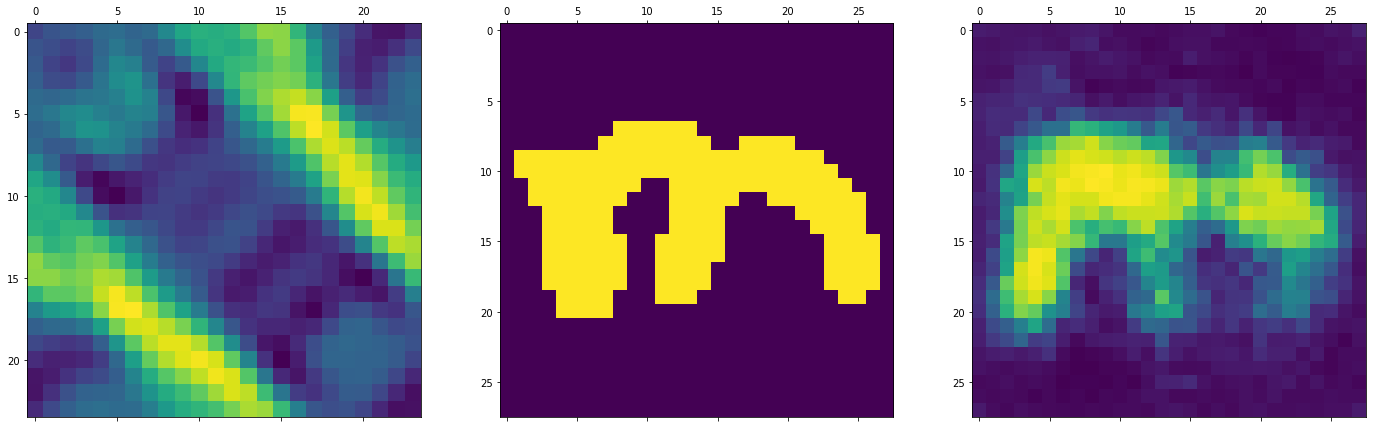

In [43]:
fig, axs = plt.subplots(1, 3, figsize=(24, 24))

axs[0].matshow(fieldMNIST_test[50])
axs[1].matshow(targetMNIST_test[50])
axs[2].matshow(pred3[50])

plt.show()

In [42]:
trained_model_cross_entropy.evaluate(fieldMNIST_test_padded, targetMNIST_test)

4/4 [==============================] - 1s 160ms/step - loss: 0.3059 - accuracy: 0.8796


[0.3059220314025879, 0.8795655369758606]

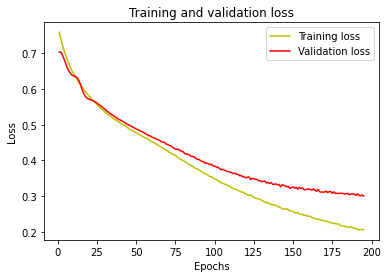

In [45]:
loss = hist_padded.history['loss']
val_loss = hist_padded.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

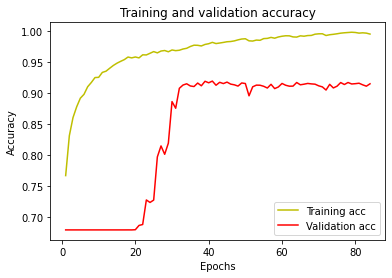

In [ ]:
acc = hist_padded.history['accuracy']
val_acc = hist_padded.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()